This notebook assumes access to detrended, denoised signals and calculates various parameters (and uncertainties) from these signals and serves as an area for experimentation with methods for parameter estimation. The parameters estimated within this notebook are split into three different types: time-domain, frequency-domain and non-linear:

Time domain:
 - mean RR intervals
 - std RR intervals 
 - mean amplitude
 - RMSSD of differences between successive RR intervals 
 - pNN50 (%) NN50 divided by total number of RR (NN50 is the number of sucessive RR intervals that differ by more than 50ms) 
 - signal moments
 
 
Frequency Domain:
- absolute power of LF (0.04 - 0.15 Hz) band
- absolute power of HF (0.15 to 0.4Hz) band
- LF/HF ratio
- Total power (0-0.4 Hz)

Non-linear:
- Fractal dimension of dynamic attractor of signal
- std of poincare
- Shannon entropy
- recurrence rate
- detrended fluctuation analysis
- correlation dimension
- sample entropy


In [227]:
%run "Data_PreProcessing.ipynb" #allowing access to the filtered database with preprocessed signals

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:04<00:00, 52.59it/s]


In [228]:
from scipy.signal import find_peaks, correlate
from pyhrv.hrv import hrv
import biosppy

In [731]:
test_indice = 134#set test signal to be used throughout notebook #219 is healthy
test_channel_indice = 1 #set test channel to be used throughout notebook
test_signal = denoised_signals[test_indice][test_channel_indice]

# Get R-peaks series using biosppy
if not np.isnan(test_signal).all():
    t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(test_signal, show=False)[:3]
    test_rpeaks =t[rpeaks]
else:
    print('test signal nan')


In [732]:
denoised_signals_one_channel = denoised_signals[:, test_channel_indice]#set test channel to be used throughout notebook

In [733]:
#finding the health array for the desired channel
nan_indices = []
health_state = allowed_patients.get_diagnoses()
for j in range(0, no_channels):
    signal_nan_indices = []
    for i, signal in enumerate(denoised_signals[:, j]):
        if np.isnan(signal).all():
            signal_nan_indices.append(False)
        else:
            signal_nan_indices.append(True)
    nan_indices.append(signal_nan_indices)
    


test_nan_indices = nan_indices[test_channel_indice]

health_state = np.array(health_state)
signal_health_state = health_state[np.array(test_nan_indices)]

In [734]:
def parameter_averages(parameter, health_state):
    """
    calculates healthy and unhealthy means and std of parameter for easy comparisson
    returns np.array containing: healthy mean, healthy std, unhealthy mean, unhealhty std
    """
    encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
    
    unhealthy_param = parameter[encoded_health_state]
    healthy_param = parameter[~np.array(encoded_health_state)]
    
    # Filter out NaN and inf values
    unhealthy_param = unhealthy_param[np.isfinite(unhealthy_param)]
    healthy_param = healthy_param[np.isfinite(healthy_param)]

    unhealthy_param_av = np.mean(unhealthy_param)
    unhealthy_param_std = np.std(unhealthy_param)
    
    healthy_param_av = np.mean(healthy_param)
    healthy_param_std = np.std(healthy_param)
    
    return np.array([healthy_param_av, healthy_param_std, unhealthy_param_av, unhealthy_param_std])

def print_averages(parameter, parameter_name, nan_indices):
    health_state = allowed_patients.get_diagnoses()

    nan_indices = np.array(nan_indices)
    health_state = np.array(health_state)
    
    channel_health_state = health_state[nan_indices]
    
    means = parameter_averages(parameter, channel_health_state)
    
    print(f"Unhealthy {parameter_name}: mean:{means[2]}, std: {means[3]}")
    print(f"Healthy {parameter_name}: mean:{means[0]}, std:{means[1]}")
    return None

def outliers_indices_z_score(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    indices = np.argwhere([abs(z)<threshold for z in z_scores])
    return indices

def get_peaks(signal):
    peak_dict, info = nk.ecg_peaks(signal, sampling_rate=1000)
    peaks = info['ECG_R_Peaks']
    
    #calculating amplitude of R peak
    peak_amp = signal[peaks] - np.median(signal) #median used as baseline
    peak_amp_av = np.mean(peak_amp)
    # peak_amp_std = np.std(peak_amp)   
    return peaks, peak_amp_av
        

def get_rri(signal, remove_outliers=False):
    peaks, amps = get_peaks(signal)

    # calculates rr intervals
    rri = np.diff(peaks)
    
    number_outliers = 0
    
    #removal of outliers
    if remove_outliers:
        rri_outlier_indices = outliers_indices_z_score(rri).reshape(-1)
        rr_intervals = rri[rri_outlier_indices]
        number_outliers += (len(rri) - len(rr_intervals))
        
    else:
        rr_intervals = rri
        number_outliers = None
    #rr_intervals = rri
        
    return rr_intervals, amps, number_outliers
    

    

## Time Domain

### Peak to Peak times and Peak amplitude (R)

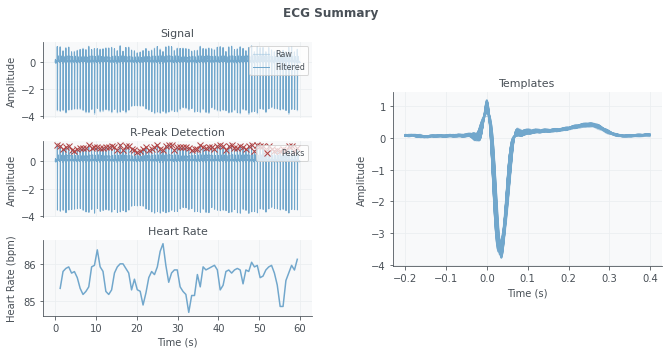

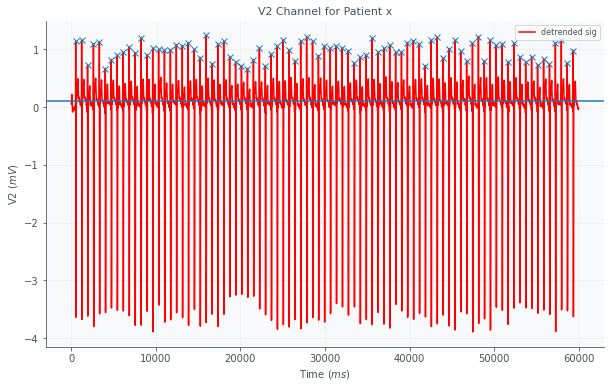

In [735]:
peaks, amp = get_peaks(test_signal)

import neurokit2 as nk 
peak_dict, info = nk.ecg_peaks(test_signal, sampling_rate=1000)
nkpeaks = info['ECG_R_Peaks']

# Get R-peaks series using biosppy
t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(test_signal)[:3]

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(test_signal, color = 'red', label = 'detrended sig')
ax.plot(nkpeaks, test_signal[nkpeaks], 'x')
ax.axhline(np.median(test_signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(f'V{test_channel_indice+1} ($mV$)')
ax.set_title(f'V{test_channel_indice+1} Channel for Patient x')

ax.legend()
plt.show()

In [736]:
import neurokit2 as nk 

peaks, info = nk.ecg_peaks(test_signal, sampling_rate=1000)

HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  700.404762  5.707993         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN   8.591815  8.643968  ...    1.006147    3.546422   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  HRV_HFD   HRV_KFD  \
0     1.410081  1.023981   1.029789    0.914771  1.193279   2.0449  5.420853   

    HRV_LZC  
0  1.217584  

[1 rows x 82 columns]

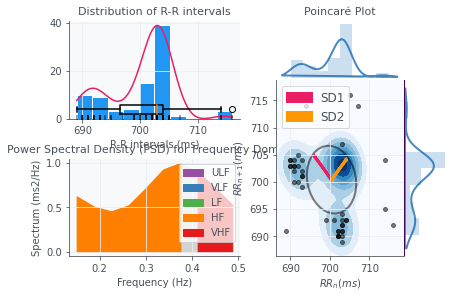

In [737]:
hrv_indices = nk.hrv(peaks, sampling_rate=1000, show=True)
hrv_indices

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN'],
      dtype='object')

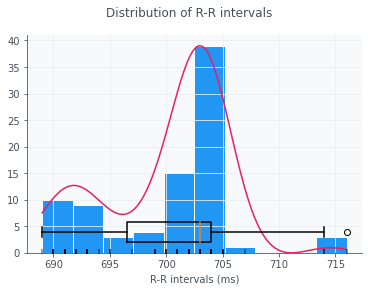

In [738]:
hrv_indices = nk.hrv_time(peaks, sampling_rate=1000, show=True)
hrv_indices.columns

identified peaks, should get rid of first and last values in it, wont hurt much even if is correct ones. I shall now implement a function to perform this for all signals in the database, may have to find a way to automatically calculate the distance between signals, find way to get rid of outliers....
- remove outliers - no because want to keep the arythmic activity
- remove first and last values
- dont investigate R-amplitude

R–R intervals differing more than 20% of the mean R–R interval were removed. A linear interpolation was used in order to replace the removed beats. On the other hand, the R–R series with R–R exclusion greater than 20% were excluded from the analysis. - Spectral analysis of heart rate variability with the autoregressive method: What model order to choose? SHOULD TRY THIS??

In [739]:
def RR_analysis(signal, remove_outliers=False):
    peak_distances, amps, number_outliers = get_rri(signal, remove_outliers)
    
    # stastitical analysis on rr intervals
    mean_RR = np.mean(peak_distances)
    std_RR = np.std(peak_distances)

    #RMSSD
    # computes differences between successive RR intervals for RMSSD
    diff_RR_intervals = np.diff(peak_distances)
    
    RMSSD_RR = np.sqrt(np.mean(diff_RR_intervals**2))
    
    #pNN50
    # the number of successive RR intervals that differ by more than 50 ms 
    NN50 = np.sum(np.abs(diff_RR_intervals) > 0.050)
    # divide by total number of RR intervals
    pNN50 = (NN50 / len(peak_distances)) * 100
    
    return mean_RR, std_RR, RMSSD_RR, pNN50, amps, number_outliers



rr_means = np.zeros(shape = len(signal_health_state))
rr_stds = np.zeros(shape = len(signal_health_state))
rr_RMSSD = np.zeros(shape = len(signal_health_state))
rr_pNN50s = np.zeros(shape = len(signal_health_state))
rr_amps = np.zeros(shape= len(signal_health_state))
n_outliers = np.zeros(shape = len(signal_health_state))
i = 0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        rr_mean, rr_std, rr_rmssd, rr_pNN50, amps, number_outliers = RR_analysis(signal, remove_outliers=True)
        rr_means[i] = rr_mean
        rr_stds[i] = rr_std
        rr_RMSSD[i] = rr_rmssd
        rr_pNN50s[i] = rr_pNN50
        rr_amps[i] = amps
        n_outliers[i] = number_outliers
        i+=1

In [740]:
print_averages(rr_means, 'RR means', test_nan_indices)
print_averages(rr_stds, 'RR stds', test_nan_indices)
print_averages(rr_RMSSD, 'RMSSDs', test_nan_indices)
print_averages(rr_pNN50s, 'pNN50s', test_nan_indices)
print_averages(rr_amps, 'amplitudes', test_nan_indices)
print_averages(n_outliers, 'num outliers', test_nan_indices)

Unhealthy RR means: mean:812.8896620872368, std: 173.3931595308604
Healthy RR means: mean:878.2699663633723, std:140.09933628910593
Unhealthy RR stds: mean:49.16687847985612, std: 68.76851029819541
Healthy RR stds: mean:34.69719005805935, std:23.47904517974324
Unhealthy RMSSDs: mean:68.58570684989976, std: 106.83590383952102
Healthy RMSSDs: mean:34.47681997924239, std:38.912278430934684
Unhealthy pNN50s: mean:91.31059839852675, std: 7.026029920154373
Healthy pNN50s: mean:95.19993278092034, std:3.024887856752692
Unhealthy amplitudes: mean:0.4411937242995569, std: 0.3843792347418914
Healthy amplitudes: mean:0.5096560509672002, std:0.2633273989747412
Unhealthy num outliers: mean:3.7883211678832116, std: 2.735094060044215
Healthy num outliers: mean:3.6666666666666665, std:1.6996731711975948


In [741]:
#comparisson with pyhrv
import pyhrv.time_domain as td

nn_means = np.zeros(shape = len(signal_health_state))
nn_stds = np.zeros(shape = len(signal_health_state))
nn_RMSSD = np.zeros(shape = len(signal_health_state))
nn_pNN50s = np.zeros(shape = len(signal_health_state))
nn_hrs = np.zeros(shape = len(signal_health_state))
nn_hrs_std = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]

        # Compute parameters using R-peak series
        nn_mean = td.nni_parameters(rpeaks=rpeaks)['nni_mean']

        nn_std = td.sdnn(rpeaks=rpeaks)['sdnn']

        nn_rmssd = td.rmssd(rpeaks=rpeaks)['rmssd']

        nn_pNN50 = td.nn50(rpeaks=rpeaks)['pnn50']

        nn_hr = td.hr_parameters(rpeaks=rpeaks)['hr_mean']
        nn_hr_std = td.hr_parameters(rpeaks=rpeaks)['hr_std']

        nn_means[i] = nn_mean
        nn_stds[i] = nn_std
        nn_RMSSD[i] = nn_rmssd
        nn_pNN50s[i] = nn_pNN50
        nn_hrs[i] = nn_hr
        nn_hrs_std[i] = nn_hr_std
        i+=1

In [742]:
print_averages(nn_means, 'nn means', test_nan_indices)
print_averages(nn_stds, 'nn stds', test_nan_indices)
print_averages(nn_RMSSD, 'nn RMSSDs', test_nan_indices)
print_averages(nn_pNN50s, 'nn pNN50s', test_nan_indices)
print_averages(nn_hrs, 'nn HR', test_nan_indices)
print_averages(nn_hrs_std, 'nn HR std', test_nan_indices)

Unhealthy nn means: mean:829.0871758825127, std: 200.51926269257197
Healthy nn means: mean:878.3377644649904, std:137.29071597740437
Unhealthy nn stds: mean:51.17629228430948, std: 59.07722960473366
Healthy nn stds: mean:45.32330558404833, std:28.476851730898044
Unhealthy nn RMSSDs: mean:70.25331783293134, std: 92.85506988910272
Healthy nn RMSSDs: mean:44.62067653913876, std:47.14319422414025
Unhealthy nn pNN50s: mean:21.788523978618024, std: 29.206402010932194
Healthy nn pNN50s: mean:14.467085171399832, std:20.385862209473206
Unhealthy nn HR: mean:76.87551401822566, std: 17.08583962733463
Healthy nn HR: mean:70.32679186754247, std:11.36106554683532
Unhealthy nn HR std: mean:4.973578445343882, std: 5.9622777313996025
Healthy nn HR std: mean:3.8553088106244435, std:2.9357736199752793


In [743]:
#neurokit
nk_nn_means = np.zeros(shape = len(signal_health_state))
nk_nn_stds = np.zeros(shape = len(signal_health_state))
nk_nn_RMSSD = np.zeros(shape = len(signal_health_state))
nk_nn_pNN50s = np.zeros(shape = len(signal_health_state))
nk_nn_iqr = np.zeros(shape = len(signal_health_state))
nk_nn_median = np.zeros(shape=len(signal_health_state))
nk_nn_mad = np.zeros(shape=len(signal_health_state))
nk_nn_HTI = np.zeros(shape=len(signal_health_state))
nk_nn_TINN = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        hrv_indices = nk.hrv_time(peaks, sampling_rate=1000, show=False)

        # Compute parameters using R-peak series
        nn_mean = hrv_indices['HRV_MeanNN']

        nn_std = hrv_indices['HRV_SDNN']

        nn_rmssd = hrv_indices['HRV_RMSSD']

        nn_pNN50 = hrv_indices['HRV_pNN50']

        nn_IQR = hrv_indices['HRV_IQRNN']

        nn_median = hrv_indices['HRV_MedianNN']

        nn_mad = hrv_indices['HRV_MadNN']

        nn_HTI = hrv_indices['HRV_HTI']

        nn_TINN = hrv_indices['HRV_TINN']

        nk_nn_means[i] = nn_mean
        nk_nn_stds[i] = nn_std
        nk_nn_RMSSD[i] = nn_rmssd
        nk_nn_pNN50s[i] = nn_pNN50
        nk_nn_iqr[i] = nn_IQR
        nk_nn_median[i] = nn_median
        nk_nn_mad[i] = nn_mad
        nk_nn_HTI[i] = nn_HTI
        nk_nn_TINN[i] = nn_TINN
        i+=1


In [744]:
print_averages(nk_nn_means, 'nn means', test_nan_indices)
print_averages(nk_nn_stds, 'nn stds', test_nan_indices)
print_averages(nk_nn_RMSSD, 'nn RMSSDs', test_nan_indices)
print_averages(nk_nn_pNN50s, 'nn pNN50s', test_nan_indices)
print_averages(nk_nn_iqr, 'nn IQR', test_nan_indices)
print_averages(nk_nn_median, 'nn median', test_nan_indices)
print_averages(nk_nn_mad, 'nn mad', test_nan_indices)
print_averages(nk_nn_HTI, 'nn HTI', test_nan_indices)
print_averages(nk_nn_TINN, 'nn TINN', test_nan_indices)


Unhealthy nn means: mean:815.584164084252, std: 176.35803565738033
Healthy nn means: mean:878.3466662904603, std:137.41094231399333
Unhealthy nn stds: mean:65.1479091082227, std: 95.70259617210995
Healthy nn stds: mean:45.270740629540434, std:27.617865659886576
Unhealthy nn RMSSDs: mean:90.89776691684565, std: 141.4488707187935
Healthy nn RMSSDs: mean:44.55273072404906, std:45.1939276657078
Unhealthy nn pNN50s: mean:25.498170620509324, std: 31.601733636356013
Healthy nn pNN50s: mean:13.896034881023292, std:20.05900157643297
Unhealthy nn IQR: mean:69.49817518248175, std: 114.0576772407099
Healthy nn IQR: mean:56.044871794871796, std:50.46501300707329
Unhealthy nn median: mean:816.8321167883212, std: 179.63084893252588
Healthy nn median: mean:879.6794871794872, std:141.43334423422039
Unhealthy nn mad: mean:49.18552554744525, std: 79.93568024613913
Healthy nn mad: mean:40.08722307692306, std:30.377016066380843
Unhealthy nn HTI: mean:5.44654209064315, std: 3.971158305207244
Healthy nn HTI:

The above suggest that in the case of the R-R time the means are different however the standard deviations are similar, however the opposite is the case for the amplitudes.

In [745]:
from scipy.stats import skew, kurtosis

def get_moments(signal, remove_outliers):
    mean = np.mean(signal)
    std = np.std(signal)
    skew_ecg = skew(signal)
    kurtosis_ecg = kurtosis(signal)
    return mean, std, skew_ecg, kurtosis_ecg

means = np.zeros(shape = len(signal_health_state))
stds = np.zeros(shape = len(signal_health_state))
skews = np.zeros(shape = len(signal_health_state))
kurtosiss = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        mean, std, ecg_skew, ecg_kurtosis = get_moments(signal, remove_outliers=True)
        means[i] = mean
        stds[i] = std
        skews[i] = ecg_skew
        kurtosiss[i] = ecg_kurtosis
        i+=1


In [746]:
print_averages(means, 'means', test_nan_indices)
print_averages(stds, 'stds', test_nan_indices)
print_averages(skews, 'skews', test_nan_indices)
print_averages(kurtosiss, "kurtosis'", test_nan_indices)

Unhealthy means: mean:-1.8225647224871563e-05, std: 0.0004239335219509913
Healthy means: mean:-8.128806695673382e-05, std:0.0003260149474202418
Unhealthy stds: mean:0.29418777729793677, std: 0.13667166554469365
Healthy stds: mean:0.2575716864004517, std:0.10291631940383068
Unhealthy skews: mean:-1.9662139731197141, std: 2.144934408805991
Healthy skews: mean:-2.62496532466493, std:1.3764096290029961
Unhealthy kurtosis': mean:11.894383393551498, std: 5.157390019915523
Healthy kurtosis': mean:13.40780408162444, std:4.96950725581495


## Frequency Domain

### Power Bands

In [747]:
from scipy.signal import welch
from scipy.interpolate import interp1d

fs = 1000 #Hz
fs_interpolate = 3 #Hz

peaks, _ = find_peaks(test_signal, distance=600)
rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
# Time points of the RR intervals
rr_times = np.cumsum(rr_intervals)
rr_times = np.insert(rr_times, 0, 0)  # Add time zero at the beginning

# Interpolation
interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector

interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)

# print(f)
# print(psd)

# Define frequency bands
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.40)

# Integrate the power spectral density over the frequency bands
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

In [748]:
def power_bands(signal):
    fs = 1000 #Hz
    fs_interpolate = 3 #Hz
    
    # define frequency bands
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.40)
    
    peak_dict, info = nk.ecg_peaks(signal, sampling_rate=1000)
    peaks = info['ECG_R_Peaks']

    rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
    # time points of the RR intervals
    rr_times = np.cumsum(rr_intervals)
    rr_times = np.insert(rr_times, 0, 0)  # add time zero at the beginning

    # Interpolation
    interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector
    interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

    #welch spectrum
    f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)
    
    # Integrate the power spectral density over the frequency bands
    lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
    hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
    
    return lf_power, hf_power, lf_power/hf_power
    

In [749]:
lfs = np.zeros(shape = len(signal_health_state))
hfs = np.zeros(shape = len(signal_health_state))
ratios = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        lf, hf, ratio = power_bands(signal)
        lfs[i] = lf
        hfs[i] = hf
        ratios[i] = ratio
        i+=1

In [750]:
print_averages(lfs, 'lf_power', test_nan_indices)
print_averages(hfs, 'hf_power', test_nan_indices)
print_averages(ratios, 'ratio of power bands', test_nan_indices)

Unhealthy lf_power: mean:0.0018064195045611033, std: 0.006068240969799988
Healthy lf_power: mean:0.0006330133393177643, std:0.0007090072848829599
Unhealthy hf_power: mean:0.005250329028099546, std: 0.016520937399383838
Healthy hf_power: mean:0.0014957155172810109, std:0.003983544180776657
Unhealthy ratio of power bands: mean:1.7479206225642665, std: 3.2728606777404154
Healthy ratio of power bands: mean:4.190617731798619, std:7.127581027129152


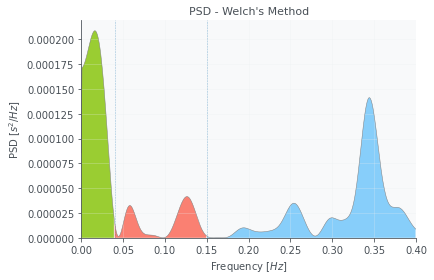

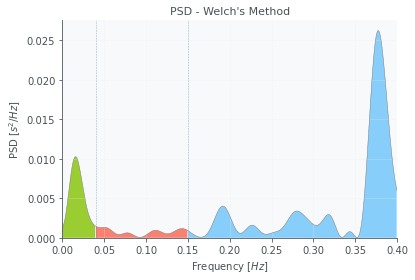

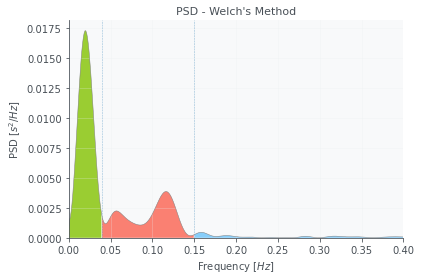

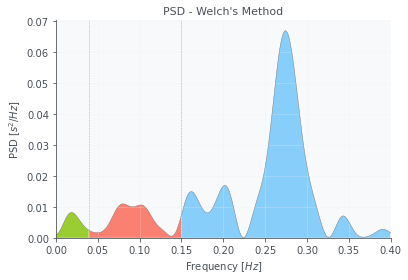

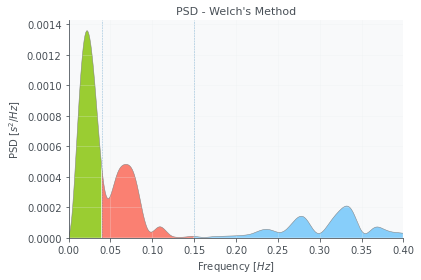

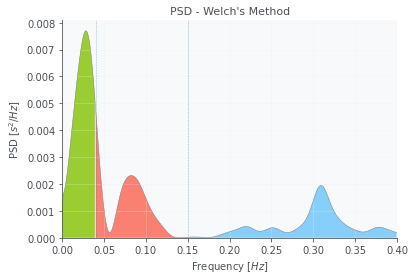

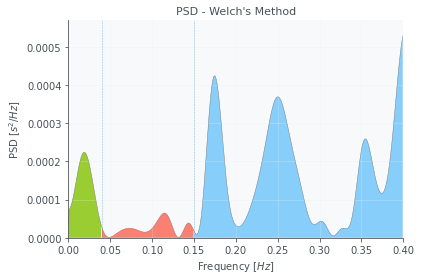

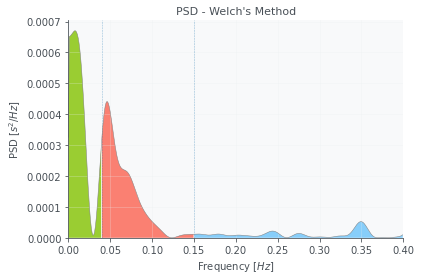

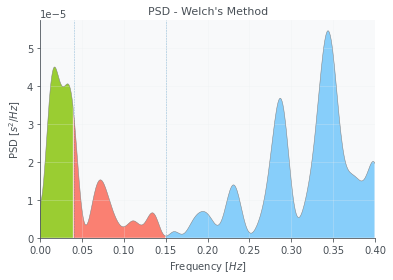

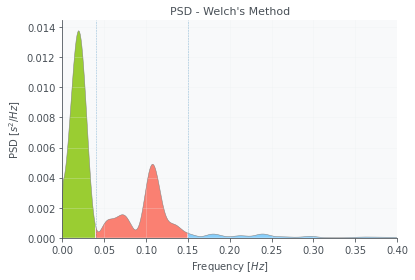

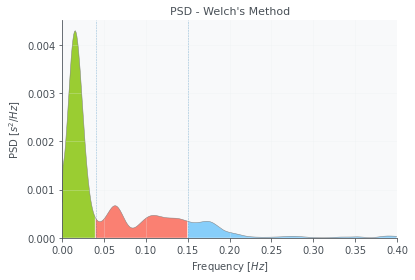

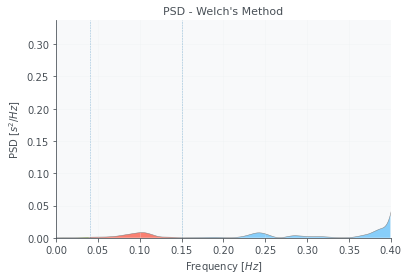

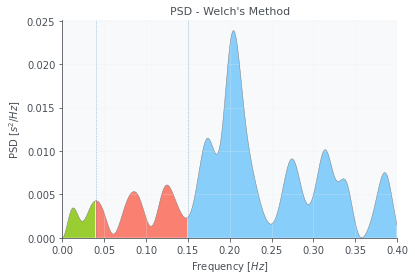

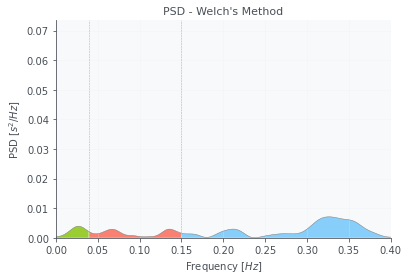

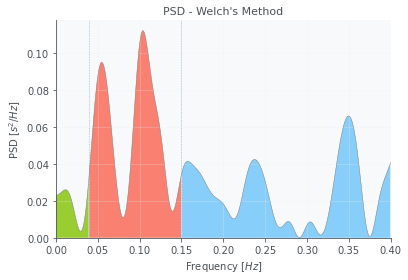

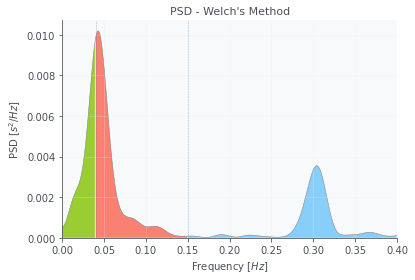

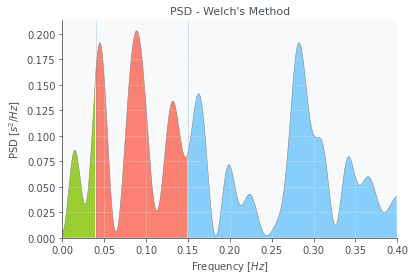

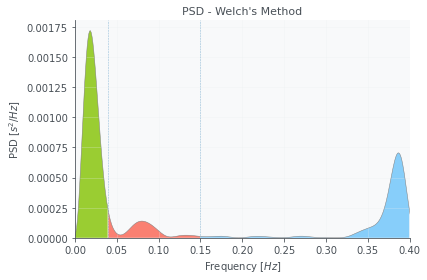

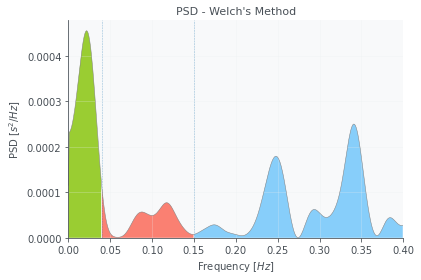

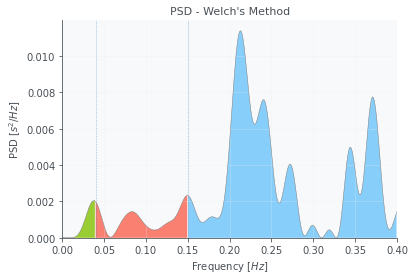

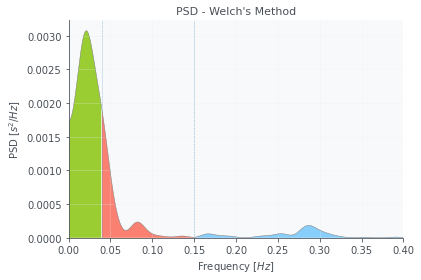

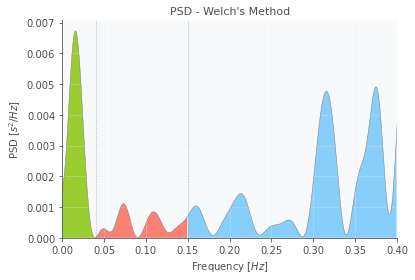

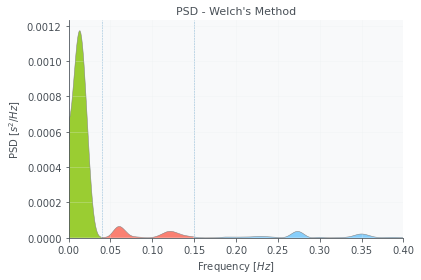

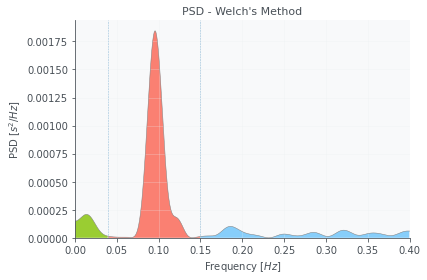

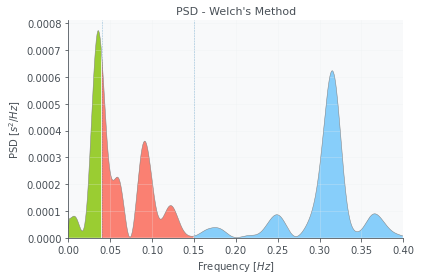

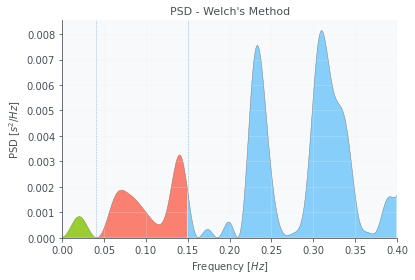

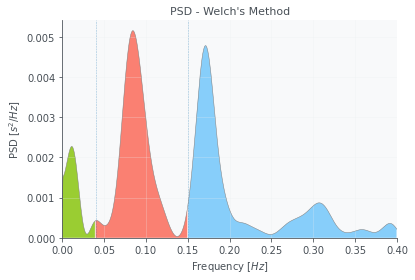

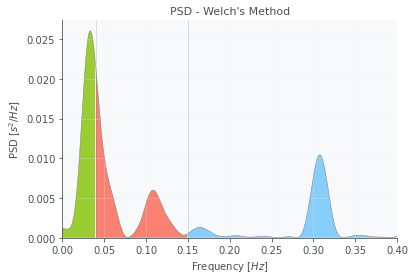

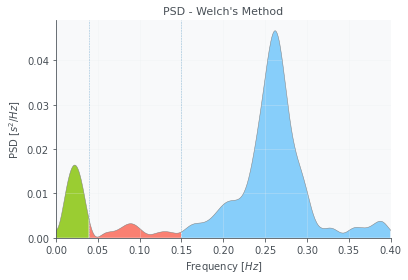

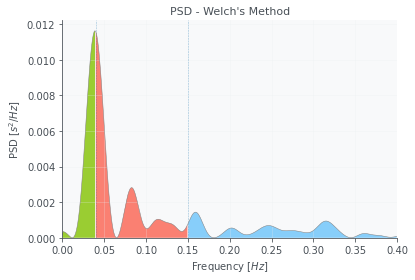

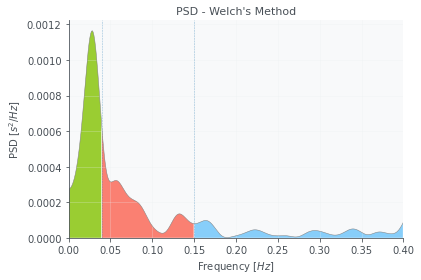

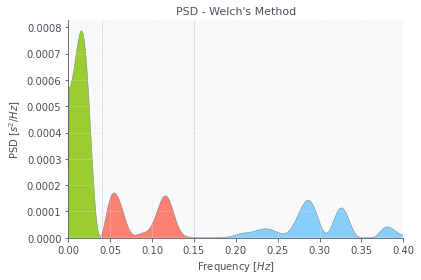

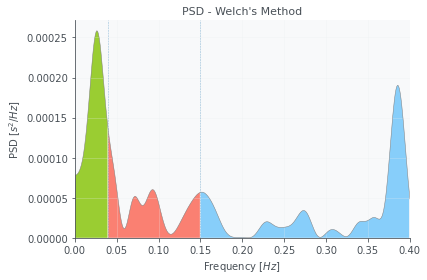

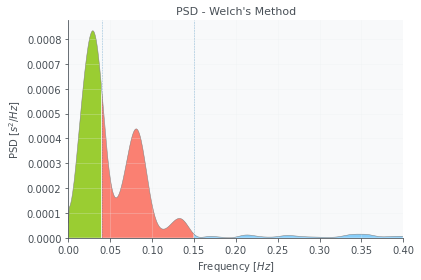

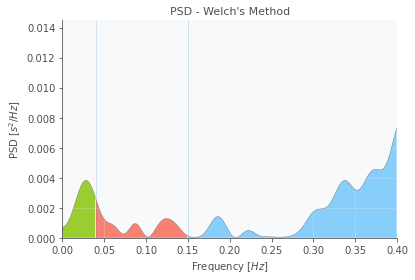

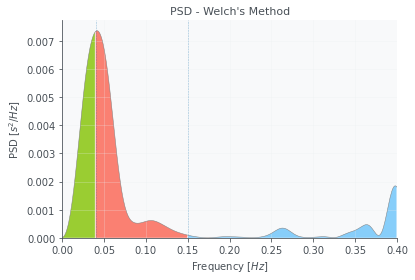

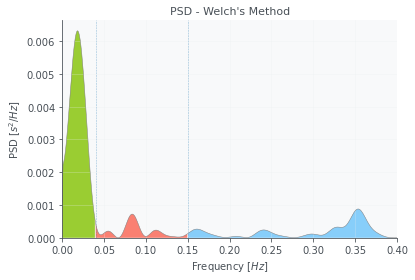

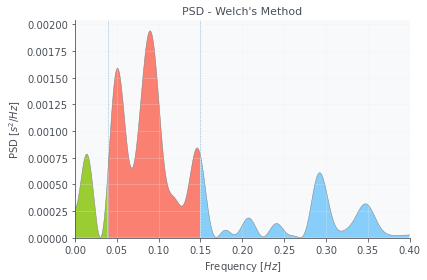

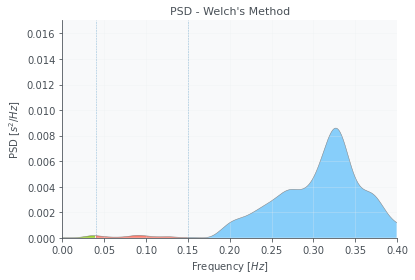

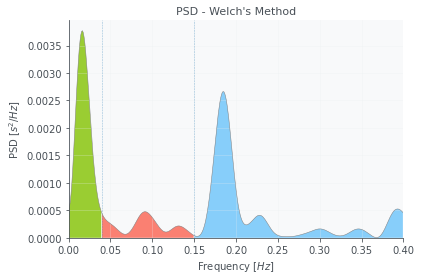

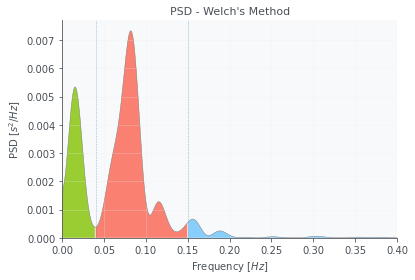

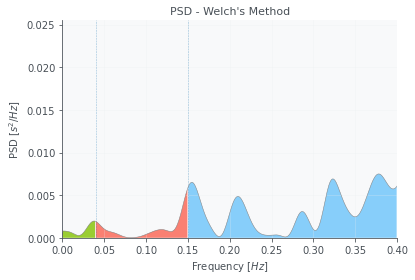

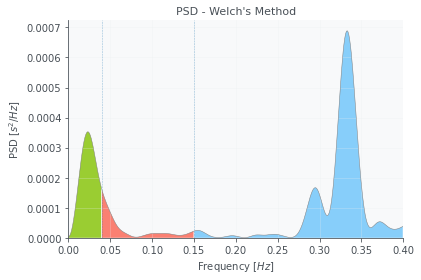

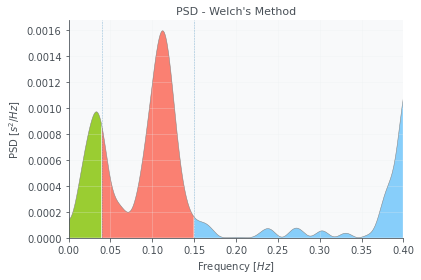

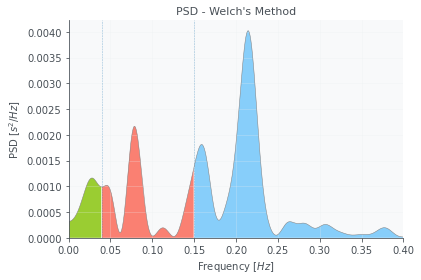

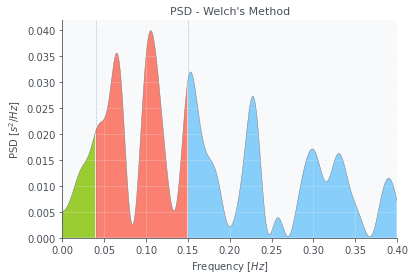

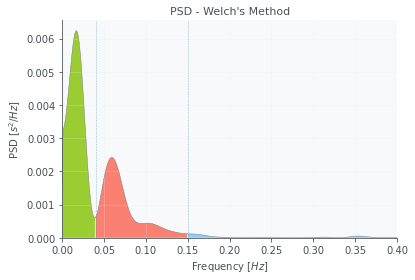

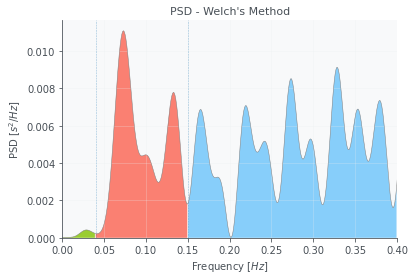

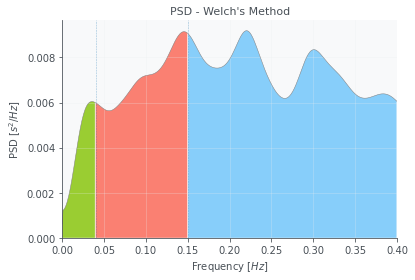

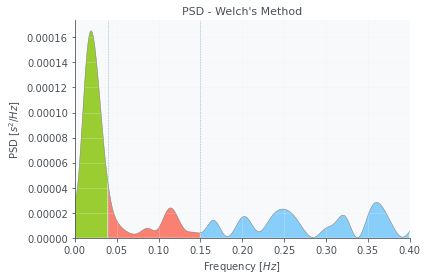

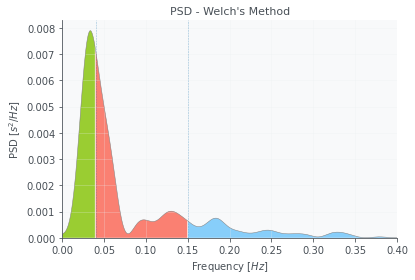

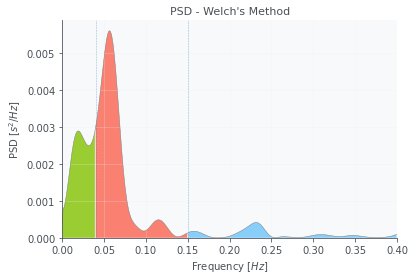

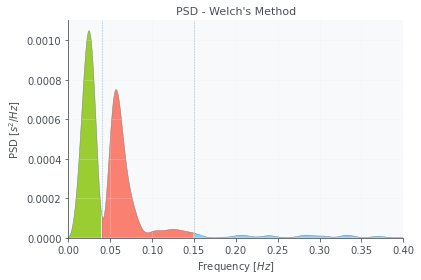

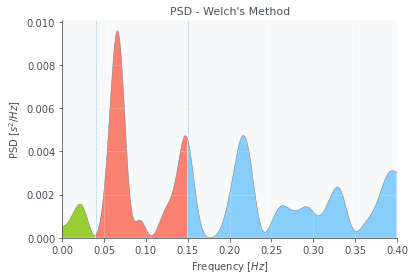

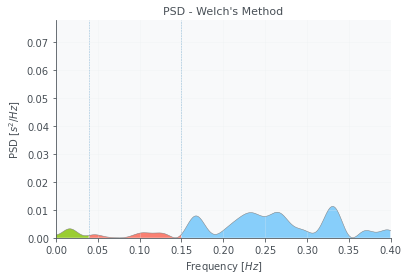

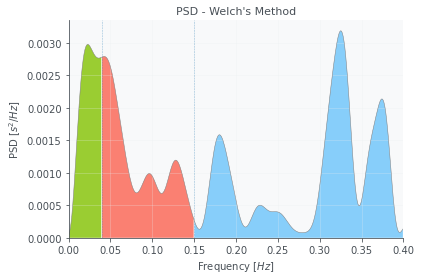

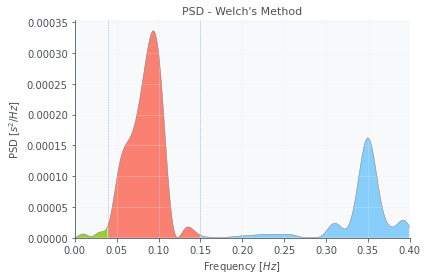

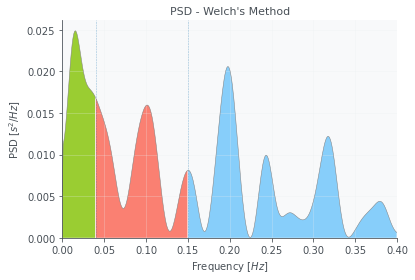

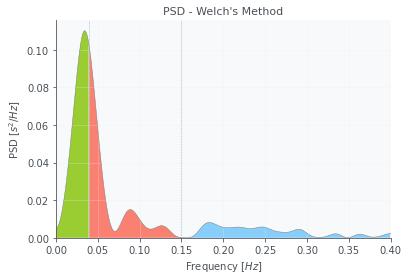

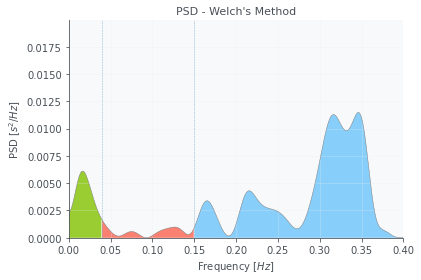

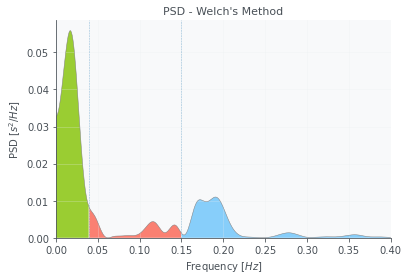

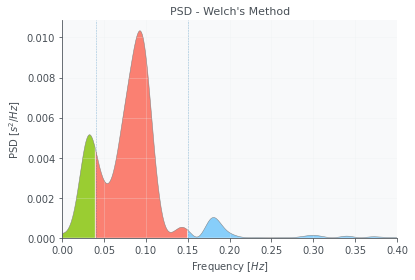

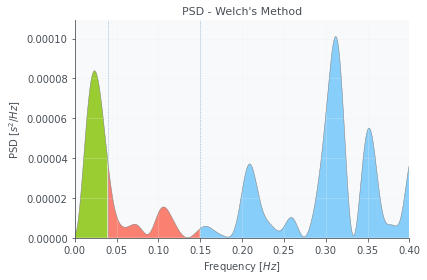

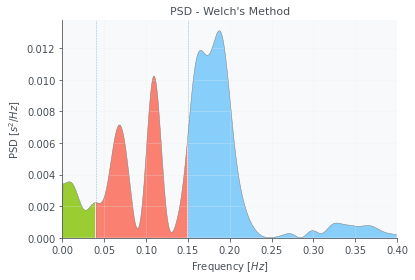

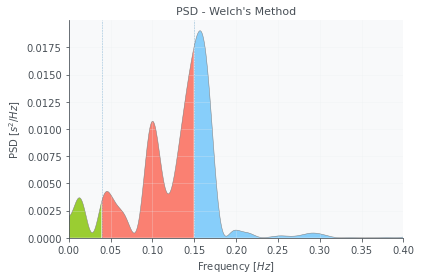

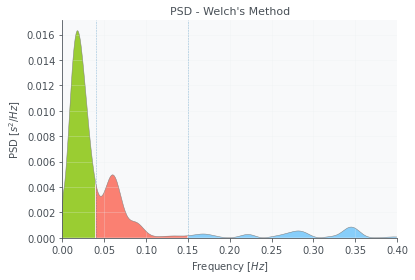

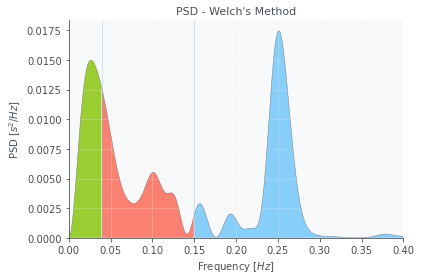

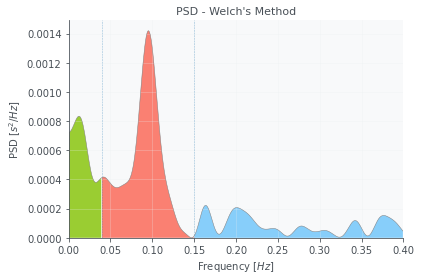

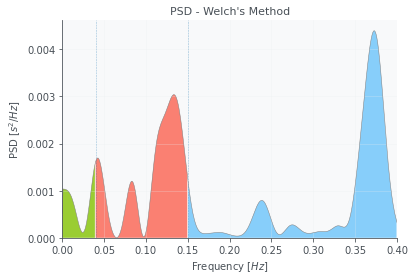

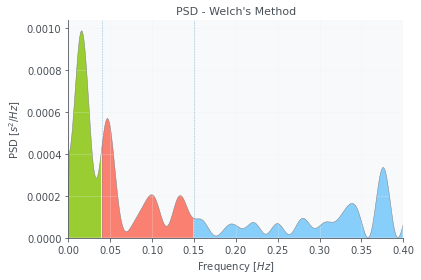

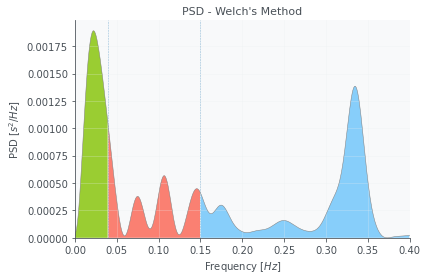

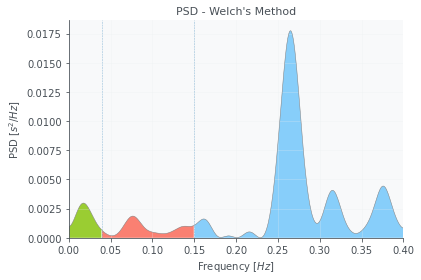

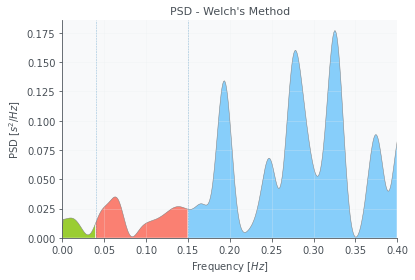

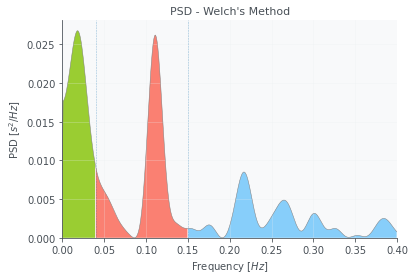

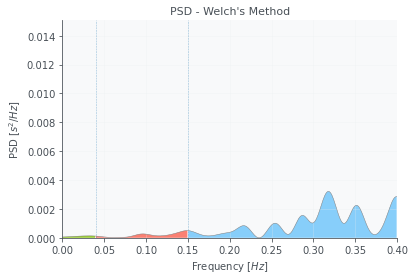

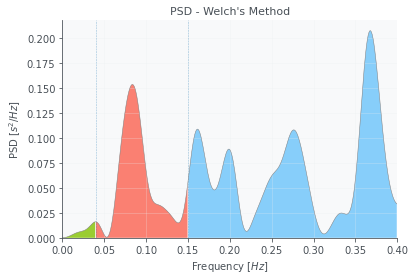

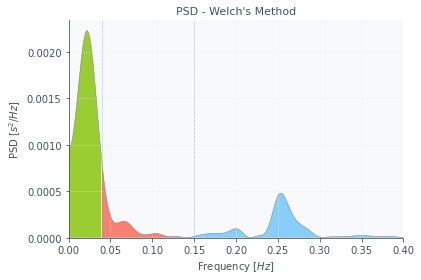

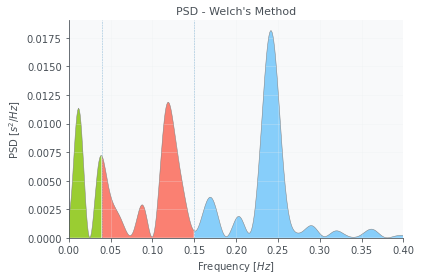

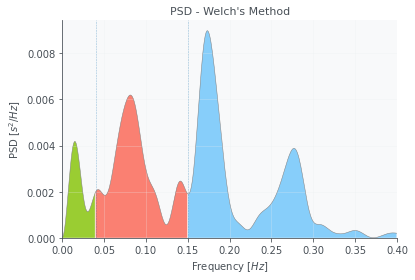

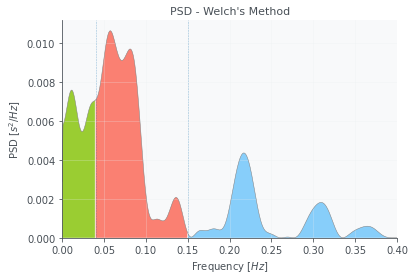

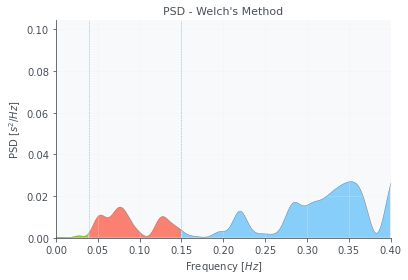

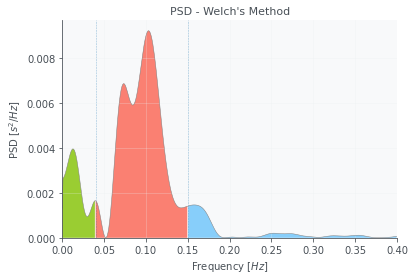

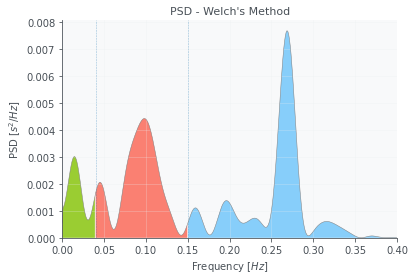

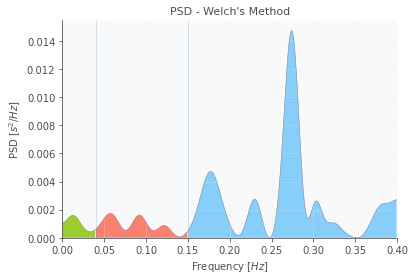

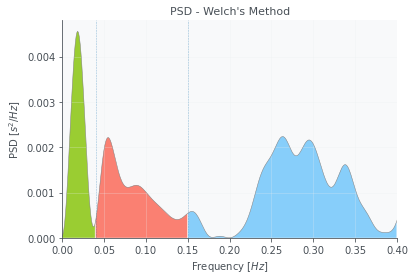

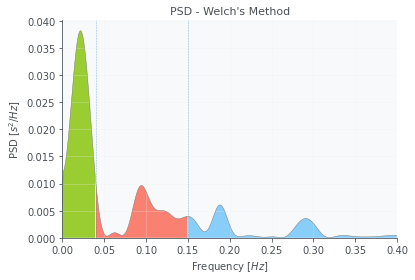

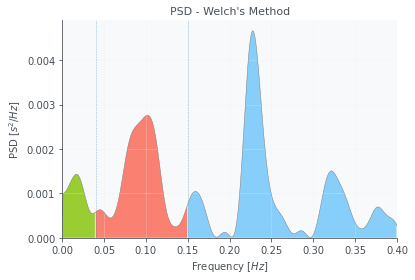

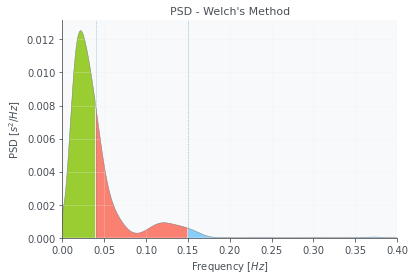

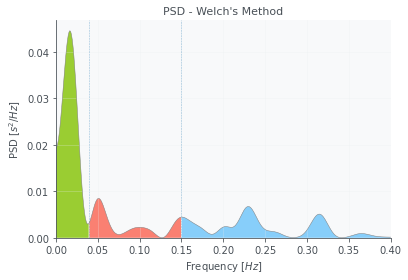

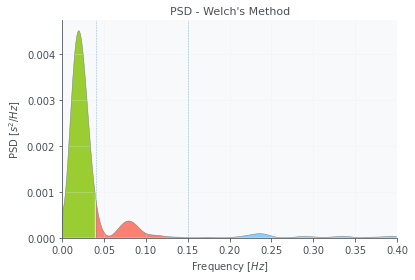

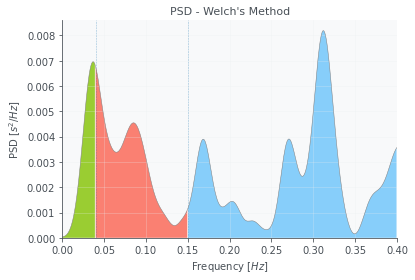

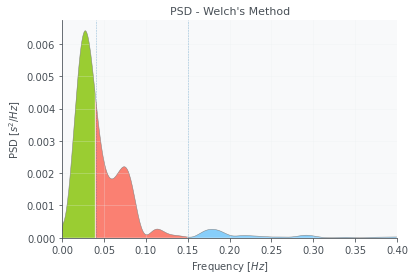

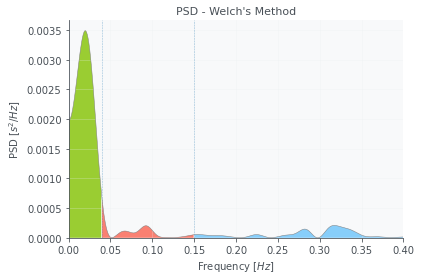

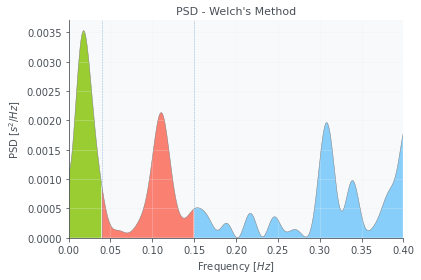

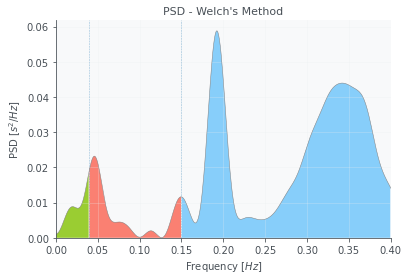

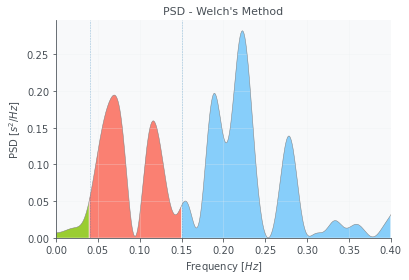

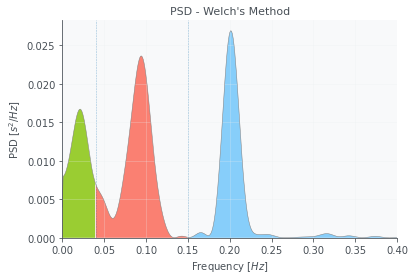

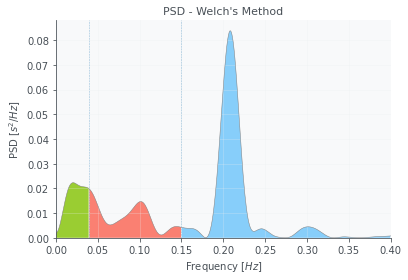

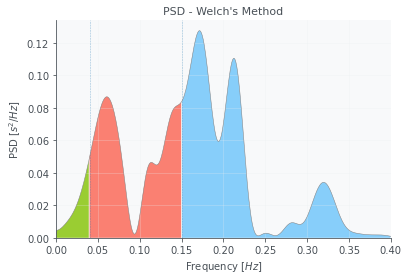

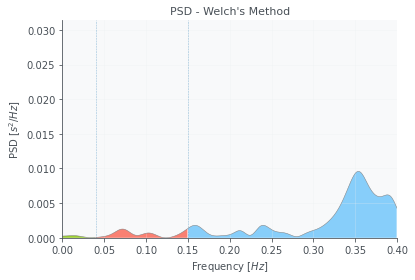

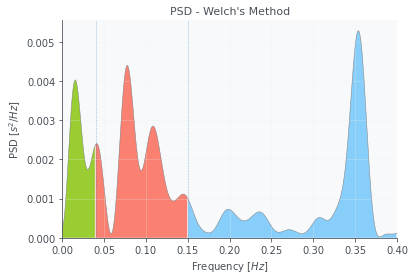

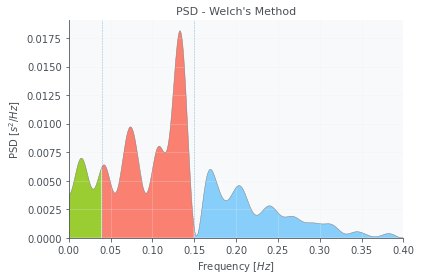

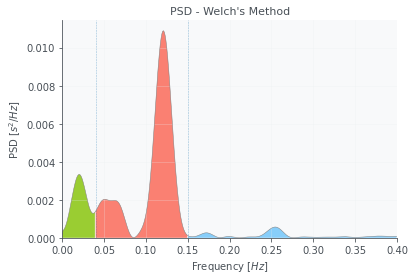

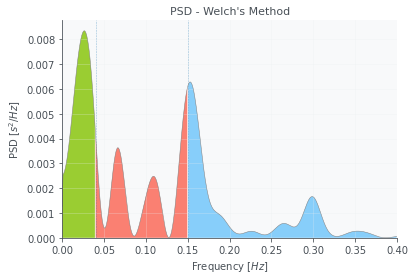

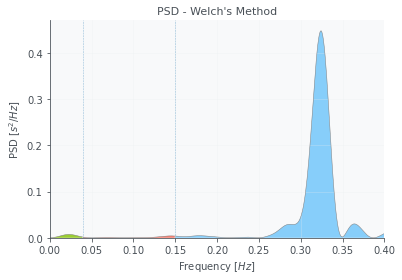

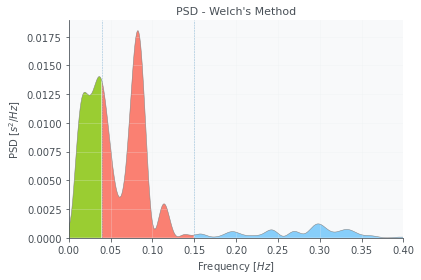

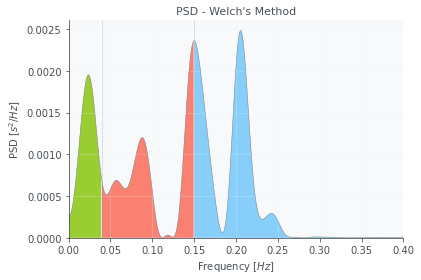

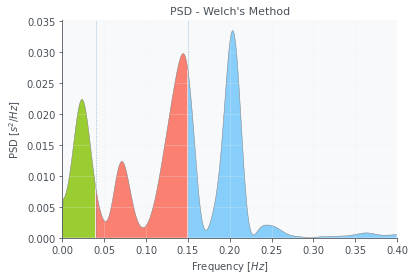

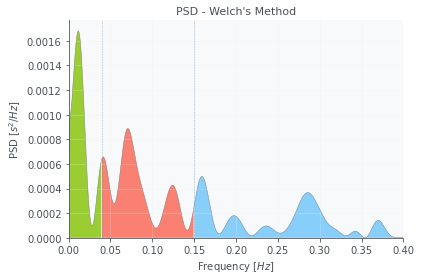

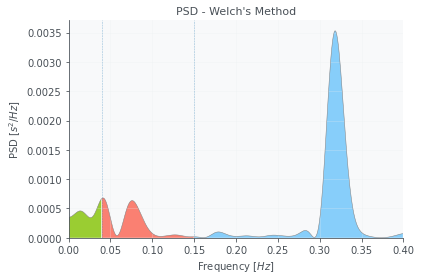

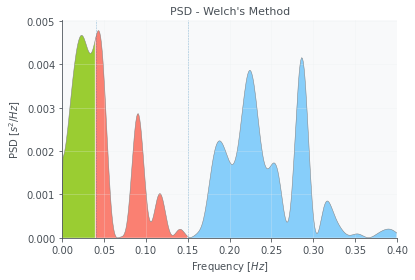

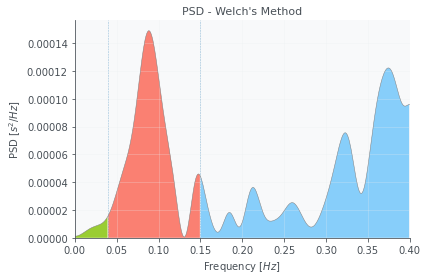

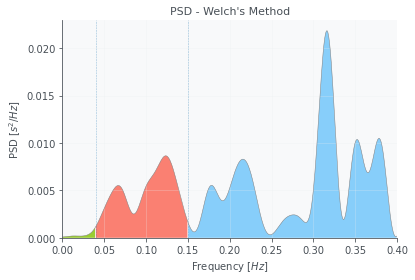

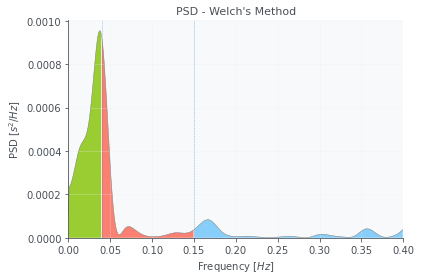

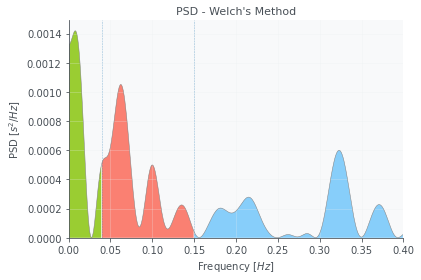

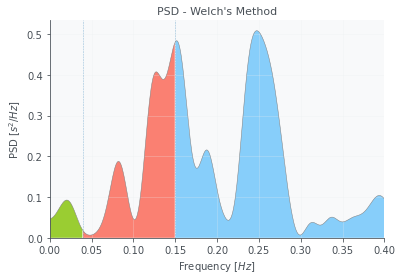

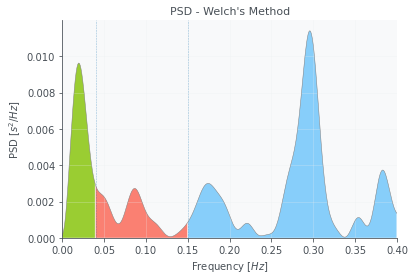

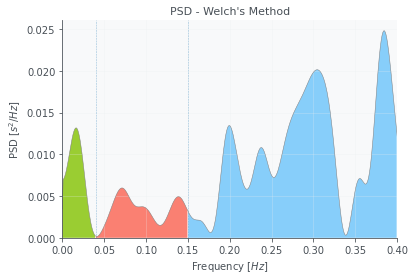

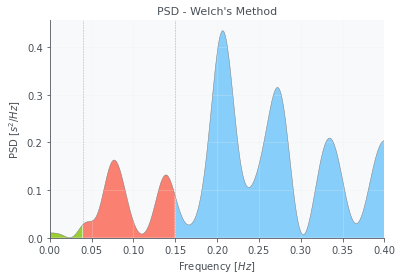

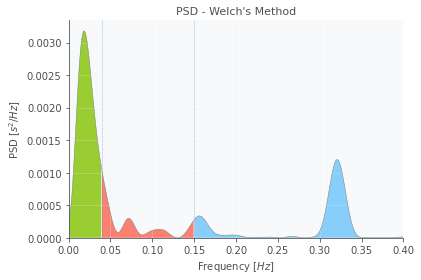

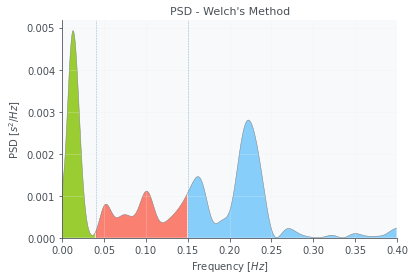

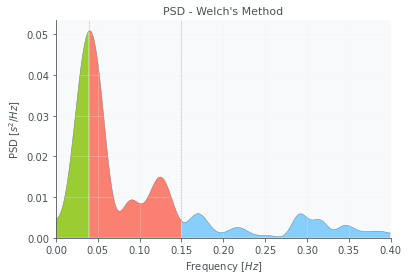

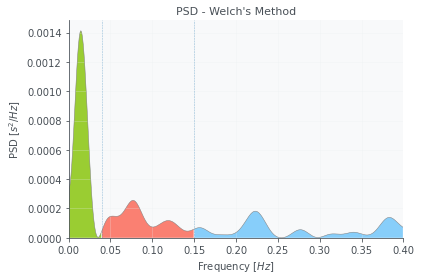

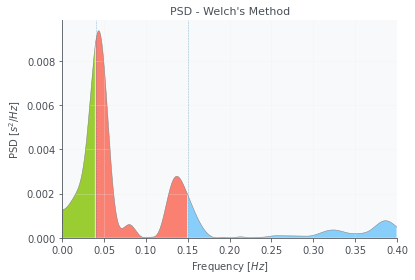

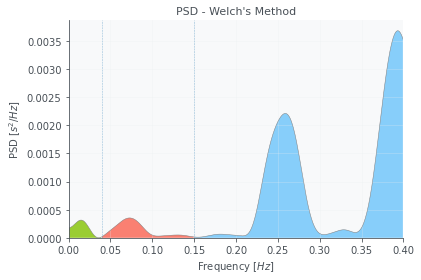

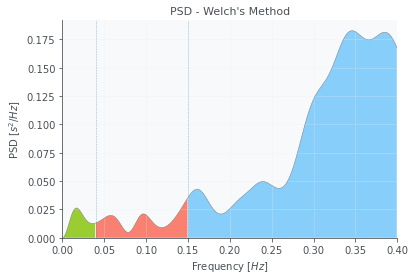

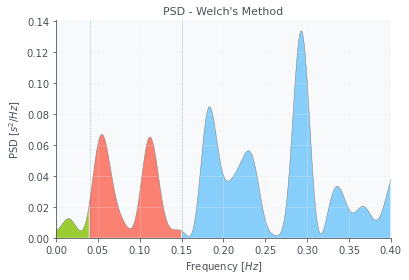

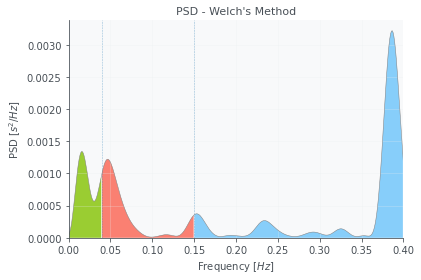

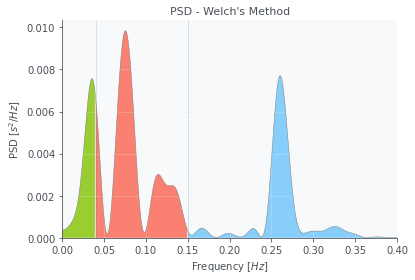

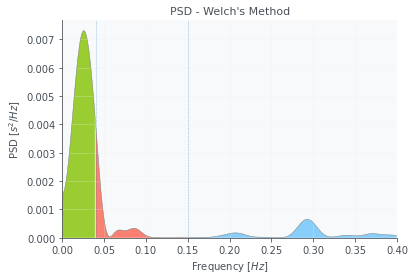

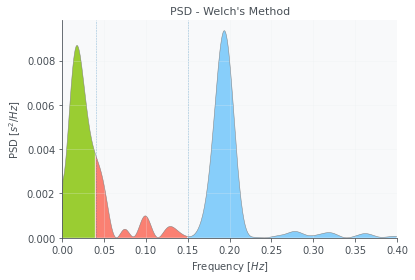

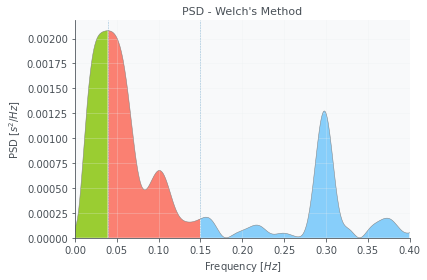

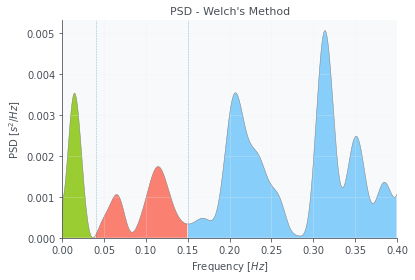

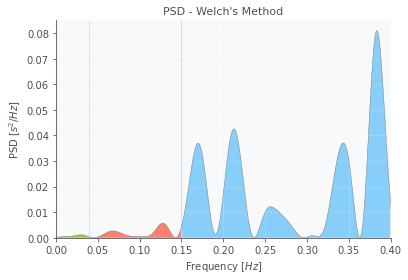

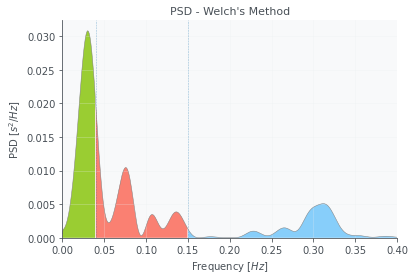

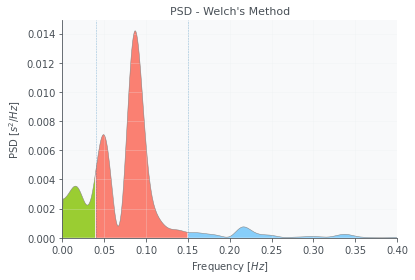

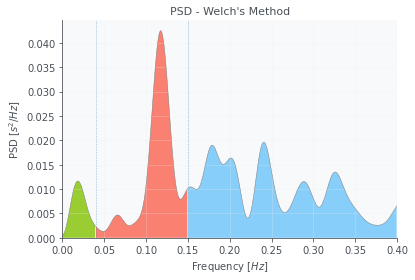

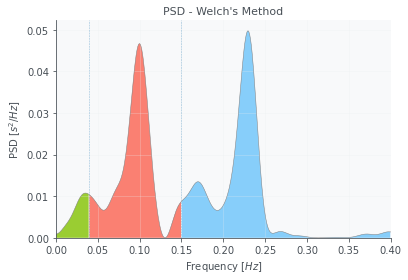

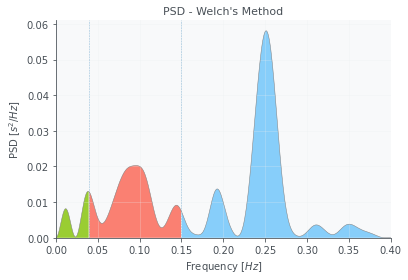

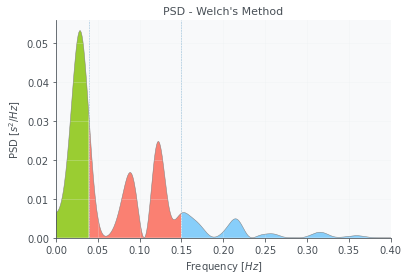

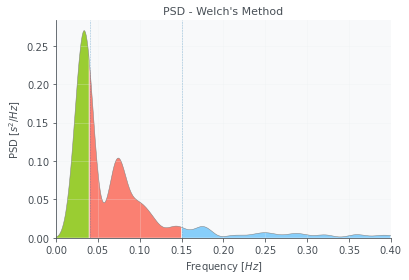

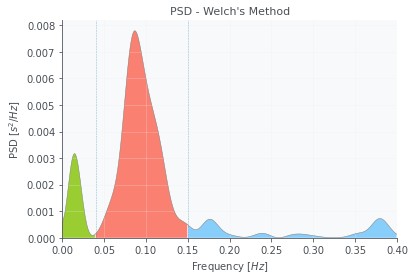

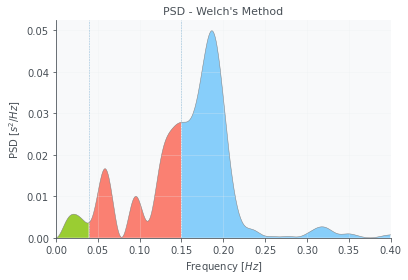

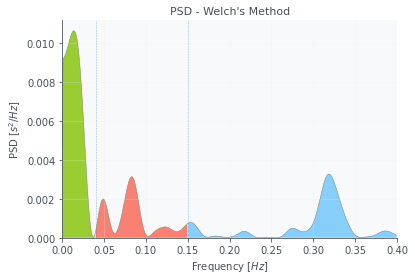

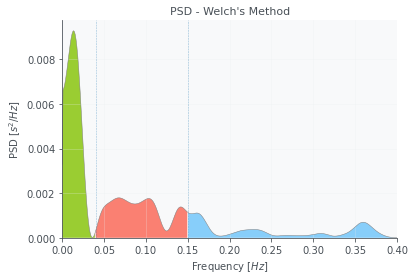

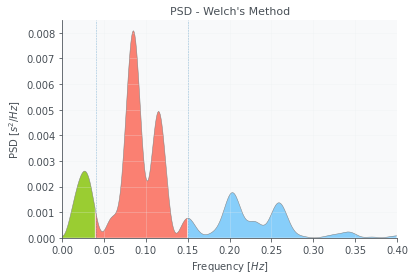

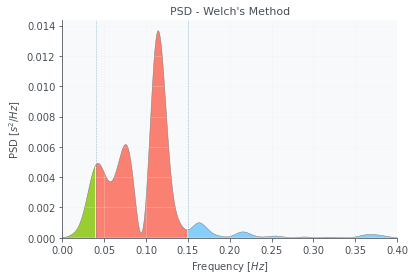

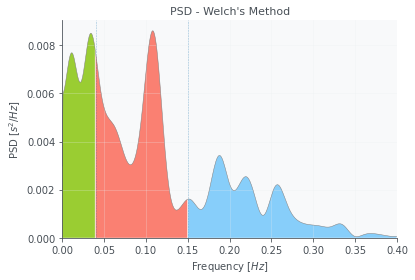

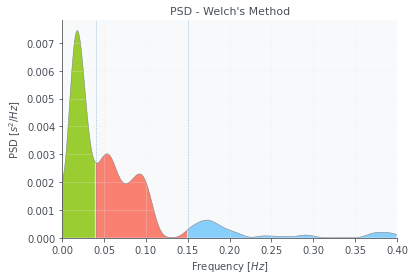

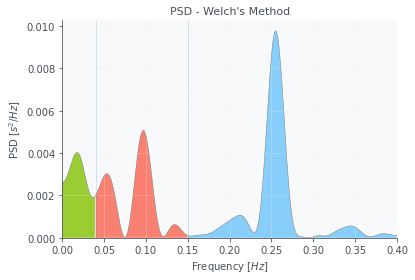

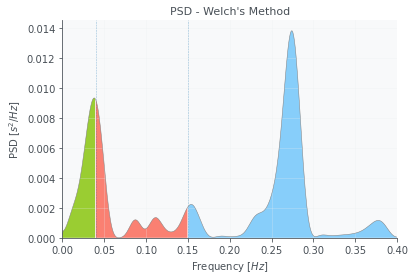

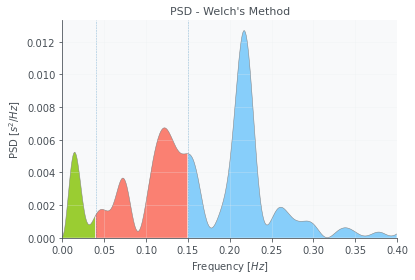

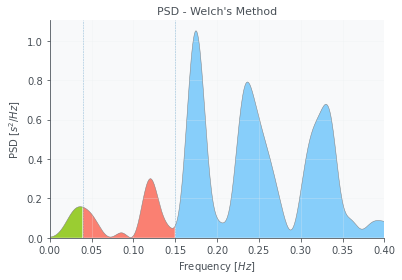

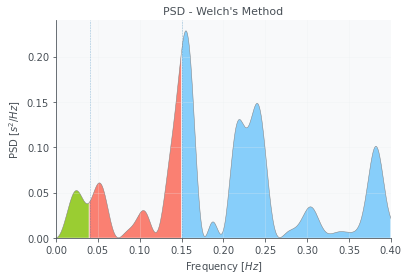

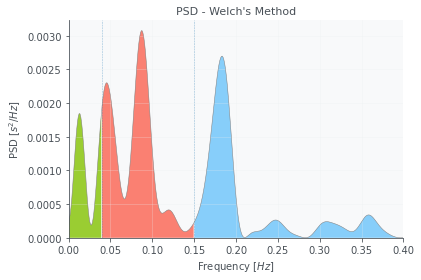

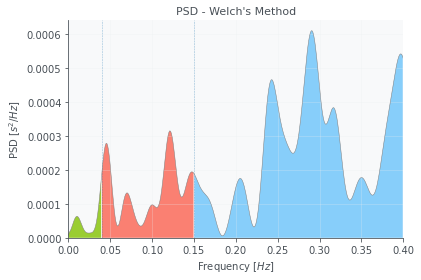

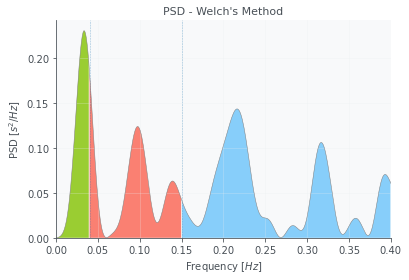

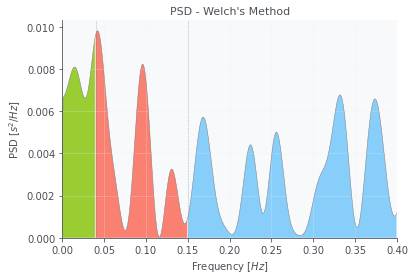

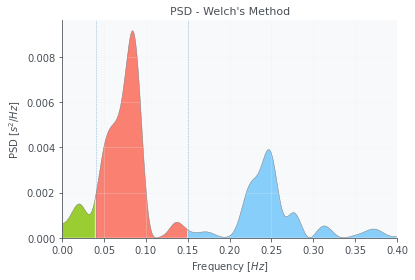

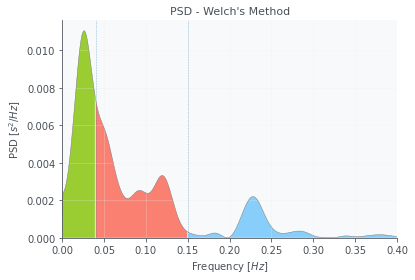

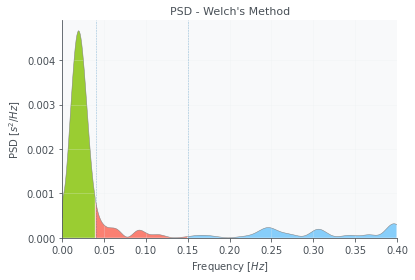

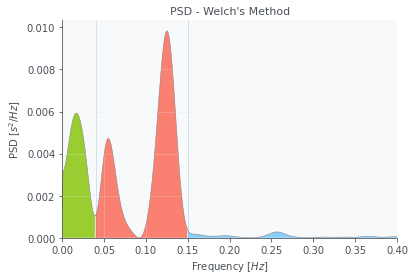

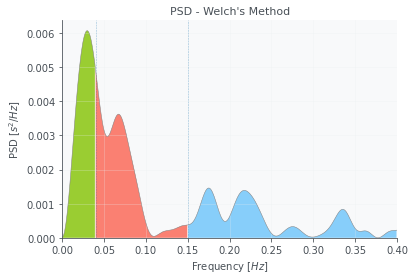

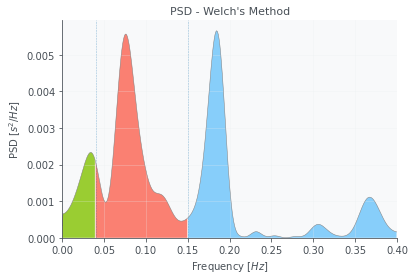

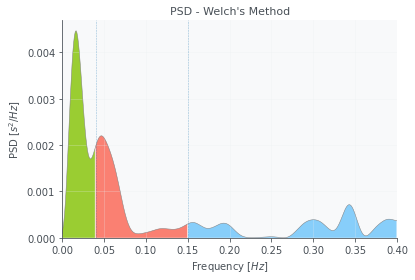

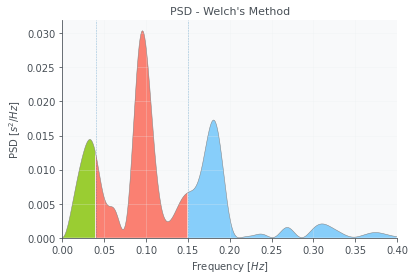

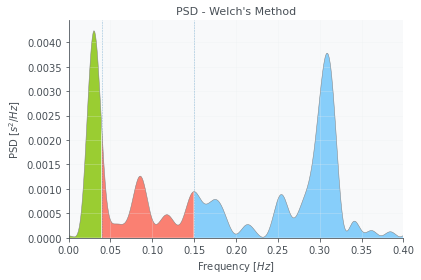

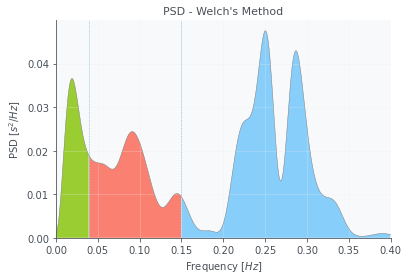

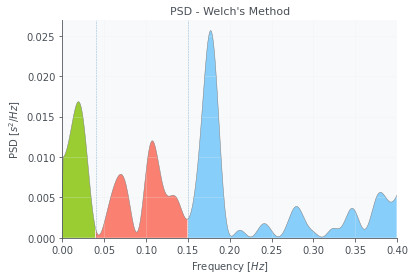

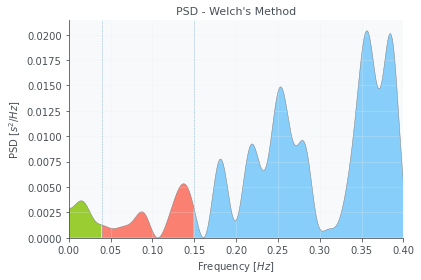

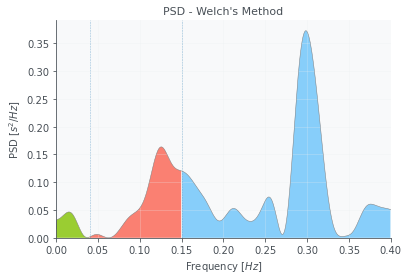

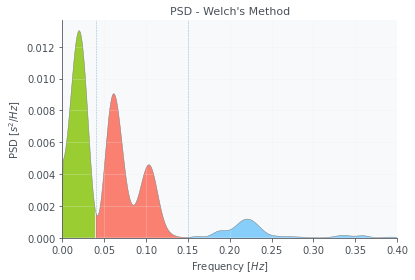

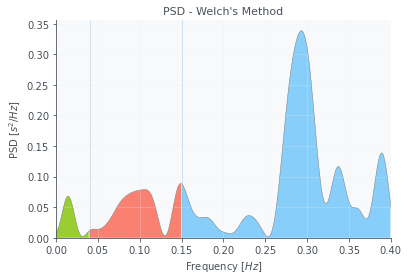

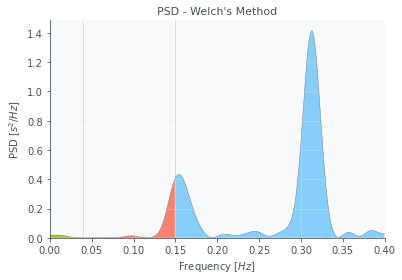

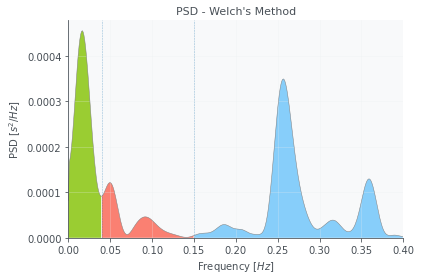

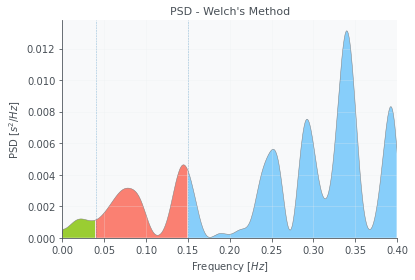

In [751]:
#comparisson with pyhrv
import pyhrv.frequency_domain as freq_dom

py_ulfs = np.zeros(shape = len(signal_health_state))
py_lfs = np.zeros(shape = len(signal_health_state))
py_hfs = np.zeros(shape = len(signal_health_state))
py_ratios = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]

        freq_feat = freq_dom.welch_psd(rpeaks = rpeaks, show = False, show_param=False, legend=False)
        py_ulfs[i] = freq_feat['fft_abs'][0]
        py_lfs[i] = freq_feat['fft_abs'][1]
        py_hfs[i] = freq_feat['fft_abs'][2]

        py_ratios[i] = freq_feat['fft_ratio']
        i+=1
    

In [752]:
print_averages(py_lfs, 'lf_power', test_nan_indices)
print_averages(py_hfs, 'hf_power', test_nan_indices)
print_averages(py_ratios, 'ratio of power bands', test_nan_indices)
print_averages(py_ulfs, 'ulf_power', test_nan_indices)

Unhealthy lf_power: mean:1048.3213368420204, std: 2734.9536835088156
Healthy lf_power: mean:693.8678570714774, std:1025.1913711383286
Unhealthy hf_power: mean:3378.571390460971, std: 10799.6900800482
Healthy hf_power: mean:1084.4164154606206, std:2219.904439907795
Unhealthy ratio of power bands: mean:1.8162190667335716, std: 3.236743895191154
Healthy ratio of power bands: mean:3.0115525420552554, std:4.23137327384377
Unhealthy ulf_power: mean:289.61577087241614, std: 597.1796354203925
Healthy ulf_power: mean:416.31712264439557, std:818.3467740393081


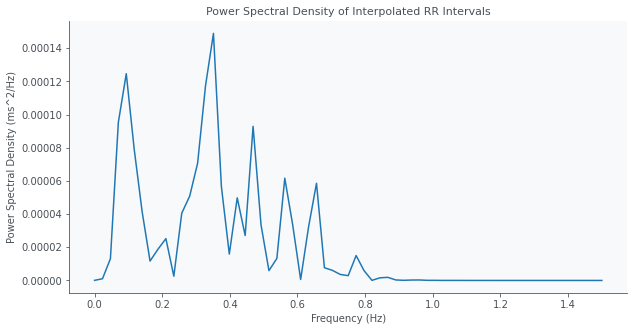

In [753]:
plt.figure(figsize=(10, 5))
plt.plot(f, psd)
plt.title('Power Spectral Density of Interpolated RR Intervals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms^2/Hz)')
plt.grid()
plt.show()

In [754]:
#neurokit
nk_ULF = np.zeros(shape = len(signal_health_state))
nk_VLF = np.zeros(shape = len(signal_health_state))
nk_LF = np.zeros(shape = len(signal_health_state))
nk_HF = np.zeros(shape = len(signal_health_state))
nk_TP = np.zeros(shape = len(signal_health_state))
nk_LFHF = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        freq_indices = nk.hrv_frequency(peaks, sampling_rate=1000, show=False)

        # Compute parameters using R-peak series
        ULF = freq_indices['HRV_ULF']

        VLF = freq_indices['HRV_VLF']

        LF = freq_indices['HRV_LF']

        HF = freq_indices['HRV_HF']

        TP = freq_indices['HRV_TP']

        power_ratio = freq_indices['HRV_LFHF']

        nk_ULF[i] = ULF
        nk_VLF[i] = VLF
        nk_LF[i] = LF
        nk_HF[i] = HF
        nk_TP[i] = TP
        nk_LFHF[i] = power_ratio
        i+=1

In [755]:
print_averages(nk_ULF, 'ULF', test_nan_indices)
print_averages(nk_VLF, 'VLF', test_nan_indices)
print_averages(nk_LF, 'LF', test_nan_indices)
print_averages(nk_HF, 'HF', test_nan_indices)
print_averages(nk_TP, 'TP', test_nan_indices)
print_averages(nk_LFHF, 'ratio', test_nan_indices)


Unhealthy ULF: mean:nan, std: nan
Healthy ULF: mean:nan, std:nan
Unhealthy VLF: mean:nan, std: nan
Healthy VLF: mean:nan, std:nan
Unhealthy LF: mean:0.020954227122386412, std: 0.01695785909529992
Healthy LF: mean:0.03216158035418336, std:0.01643709505692664
Unhealthy HF: mean:0.062218693101615874, std: 0.0466631977406336
Healthy HF: mean:0.04255937909867169, std:0.031278735814416675
Unhealthy TP: mean:0.10038407906754981, std: 0.06584902008659525
Healthy TP: mean:0.07700626576398913, std:0.03610004934078585
Unhealthy ratio: mean:0.8752488021013055, std: 1.610121101489895
Healthy ratio: mean:1.8105816445044987, std:2.1293532361279666


### DWT


In [756]:
def single_DWT(signal, wavelet='db4'):
    coeffs = pywt.dwt(signal, wavelet)
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    

In [757]:
DWT_means = np.zeros(shape = (len(signal_health_state), 2))
DWT_stds = np.zeros(shape = (len(signal_health_state), 2))
DWT_mins = np.zeros(shape = (len(signal_health_state), 2))
DWT_maxs = np.zeros(shape = (len(signal_health_state), 2))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        DWT_mean, DWT_std, DWT_min, DWT_max = single_DWT(signal)
        DWT_means[i] = DWT_mean 
        DWT_stds[i] = DWT_std
        DWT_mins[i] = DWT_min
        DWT_maxs[i] = DWT_max
        i+=1

In [758]:
print_averages(DWT_means[:, 0], 'mean approx coeff', test_nan_indices)
print('---')
print_averages(DWT_means[:, 1], 'mean detail coeff', test_nan_indices)
print('---')
print_averages(DWT_stds[:, 0], 'std approx coeff', test_nan_indices)
print('---')
print_averages(DWT_stds[:, 1], 'std detail coeff', test_nan_indices)
print('---')
print_averages(DWT_mins[:, 0], 'min approx coeff', test_nan_indices)
print('---')
print_averages(DWT_mins[:, 1], 'min detail coeff', test_nan_indices)
print('---')
print_averages(DWT_maxs[:, 0], 'max approx coeff', test_nan_indices)
print('---')
print_averages(DWT_maxs[:, 1], 'max detail coeff', test_nan_indices)

Unhealthy mean approx coeff: mean:-2.2241100279468305e-05, std: 0.0005886757184265938
Healthy mean approx coeff: mean:-0.00011367371644421118, std:0.0004570186791277692
---
Unhealthy mean detail coeff: mean:-1.222341024036992e-09, std: 1.879953656283594e-08
Healthy mean detail coeff: mean:2.8058264557310445e-09, std:1.6388451037661483e-08
---
Unhealthy std approx coeff: mean:0.41602873224287507, std: 0.19327534923656914
Healthy std approx coeff: mean:0.36424497096970504, std:0.14553889222125654
---
Unhealthy std detail coeff: mean:2.943272727006631e-06, std: 5.421785576464732e-06
Healthy std detail coeff: mean:2.18812209526788e-06, std:4.493583198279598e-06
---
Unhealthy min approx coeff: mean:-2.2830103065738436, std: 1.1720519550416344
Healthy min approx coeff: mean:-2.2472819947489686, std:0.9534664550918854
---
Unhealthy min detail coeff: mean:-0.00033294930129314085, std: 0.000632523811902271
Healthy min detail coeff: mean:-0.00021910988176320053, std:0.0004087252637330745
---
Unh

In [759]:
def multi_DWT(signal, level, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    
level = 8
    
multi_DWT_means = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_stds = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_mins = np.zeros(shape = (len(signal_health_state), level+1))
multi_DWT_maxs = np.zeros(shape = (len(signal_health_state), level+1))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        multi_DWT_mean, multi_DWT_std, multi_DWT_min, multi_DWT_max = multi_DWT(signal, level)
        multi_DWT_means[i] = multi_DWT_mean 
        multi_DWT_stds[i] = multi_DWT_std
        multi_DWT_mins[i] = multi_DWT_min
        multi_DWT_maxs[i] = multi_DWT_max
        i+=1



In [760]:
for i in range(0, multi_DWT_means.shape[1]):
    print_averages(multi_DWT_means[:, i], f'mean approx coeff {i}', test_nan_indices)
    print('---')
    

Unhealthy mean approx coeff 0: mean:0.009123707007705869, std: 0.053286724586056586
Healthy mean approx coeff 0: mean:0.002043714523088715, std:0.027653532758591268
---
Unhealthy mean approx coeff 1: mean:-0.0010424557559340446, std: 0.1303949462357507
Healthy mean approx coeff 1: mean:0.039859129224666175, std:0.0955891750430607
---
Unhealthy mean approx coeff 2: mean:0.00021224217315925128, std: 0.06314854307631375
Healthy mean approx coeff 2: mean:-0.0013748446495785085, std:0.06343189834151844
---
Unhealthy mean approx coeff 3: mean:0.0011929158522425397, std: 0.04063197139651438
Healthy mean approx coeff 3: mean:-0.0016958870130664681, std:0.025818003292023436
---
Unhealthy mean approx coeff 4: mean:-0.00013857065265763805, std: 0.0042969783981691104
Healthy mean approx coeff 4: mean:-0.00047302711622875773, std:0.0048374850052892455
---
Unhealthy mean approx coeff 5: mean:2.4763165647771535e-08, std: 1.0617328100235134e-05
Healthy mean approx coeff 5: mean:-1.2932378139990186e-06

## Non-Linear Domain

### Standard deviation of Poincare Plot
plot of each rr interval against the next, essentially a phase plot

In [761]:
def plot_poincare(rr_intervals, compare=False):
    x = rr_intervals[:-1]
    y = rr_intervals[1:]
    
    if compare:
        removed_outliers = rr_intervals[outliers_indices_z_score(rr_intervals)]
        filtx = removed_outliers[:-1]
        filty = removed_outliers[1:]
        diff = len(rr_intervals) - len(removed_outliers)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
        ax2.scatter(filtx, filty, s=10, alpha=0.5)
        ax2.plot(filtx, filtx, color='red', linestyle='--')  # Line of identity (y = x)
        ax2.set_title(f'Poincaré Plot, Removed {diff} samples')
        ax2.set_xlabel('RR_n (ms)')
        ax2.set_ylabel('RR_{n+1} (ms)')
        ax2.grid()
        
    else:
        fig, ax1 = plt.subplots()

    ax1.scatter(x, y, s=10, alpha=0.5)
    ax1.plot(x, x, color='red', linestyle='--')  # Line of identity (y = x)
    ax1.set_title('Poincaré Plot')
    ax1.set_xlabel('RR_n (ms)')
    ax1.set_ylabel('RR_{n+1} (ms)')
    ax1.grid(True)
    ax1.axis('equal')  # Ensure aspect ratio is equal
    plt.show()
    return None
    
def calculate_poincare_sd(sig, remove_outliers=False):
    #get rr intervals
    rr_intervals = get_rri(sig)[0]
    
    if remove_outliers:
        rr_intervals = rr_intervals[outliers_indices_z_score(rr_intervals)]
        
    #separating into subsequent coordinates for Poincaré plot
    rr_n = rr_intervals[:-1]
    rr_n1 = rr_intervals[1:]
    
    #calculating SD1, perpendicular to y=x
    diff_rr = np.array(rr_n) - np.array(rr_n1)
    sd1 = np.sqrt(np.var(diff_rr/np.sqrt(2)))
    
    # calculating SD2, along y=x
    sum_rr = rr_n + rr_n1
    sd2 = np.sqrt(np.var(sum_rr/np.sqrt(2)))
    
    # calculating ratio
    sd_ratio = sd2/sd1
   
    #counting intervals outside SD1 and SD2
    count_outside_sd1 = np.sum(np.abs(diff_rr / np.sqrt(2)) > sd1)
    count_outside_sd2 = np.sum(np.abs(sum_rr / np.sqrt(2)) > sd2)

    out = count_outside_sd1 + count_outside_sd2
    return sd1, sd2, sd_ratio, count_outside_sd1, count_outside_sd2, out


In [762]:
# rr_intervals = get_rri(signals[9])[0]
# plot_poincare(rr_intervals, compare = True)

In [763]:
sd1s = np.zeros(shape = len(signal_health_state))
sd2s = np.zeros(shape = len(signal_health_state))
sd_ratios = np.zeros(shape=len(signal_health_state))
out_sd1s = np.zeros(shape=len(signal_health_state))
out_sd2s = np.zeros(shape=len(signal_health_state))
n_out = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        sd1, sd2, sd_ratio, out_sd1, out_sd2, out = calculate_poincare_sd(signal)
        sd1s[i] = sd1
        sd2s[i] = sd2
        sd_ratios[i] = sd_ratio
        out_sd1s[i] = out_sd1
        out_sd2s[i] = out_sd2
        n_out[i] = out
        i+=1

In [764]:
print_averages(sd1s, 'sd1s', test_nan_indices)
print_averages(sd2s, 'sd2s', test_nan_indices)
print_averages(sd_ratios, 'sd ratio', test_nan_indices)
print_averages(out_sd1s, 'sd1 outlier', test_nan_indices)
print_averages(out_sd2s, 'sd2 outlier', test_nan_indices)
print_averages(n_out, 'n out', test_nan_indices)

Unhealthy sd1s: mean:64.25723111661146, std: 99.97321629382134
Healthy sd1s: mean:31.493249974503186, std:31.9584412921972
Unhealthy sd2s: mean:61.52465758544588, std: 89.20842069648168
Healthy sd2s: mean:53.02039383286197, std:26.56141112985713
Unhealthy sd ratio: mean:1.5225700553568753, std: 0.9524473446389506
Healthy sd ratio: mean:2.2535403343386657, std:0.8737564378886981
Unhealthy sd1 outlier: mean:22.963503649635037, std: 10.704667621758391
Healthy sd1 outlier: mean:18.384615384615383, std:6.814823152192634
Unhealthy sd2 outlier: mean:74.43795620437956, std: 16.15701303692778
Healthy sd2 outlier: mean:67.74358974358974, std:11.306267716529781
Unhealthy n out: mean:97.4014598540146, std: 24.23530026409254
Healthy n out: mean:86.12820512820512, std:15.29400668131732


In [765]:
#with outliers removed
sd1s = np.zeros(shape = len(signal_health_state))
sd2s = np.zeros(shape =len(signal_health_state))
sd_ratios = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        sd1, sd2, sd_ratio = calculate_poincare_sd(signal, remove_outliers=True)[:3]
        sd1s[i] = sd1
        sd2s[i] = sd2
        sd_ratios[i] = sd_ratio
        i+=1

In [766]:
print_averages(sd1s, 'sd1s', test_nan_indices)
print_averages(sd2s, 'sd2s', test_nan_indices)
print_averages(sd_ratios, 'sd ratio', test_nan_indices)

Unhealthy sd1s: mean:48.49011211967457, std: 75.53638420638559
Healthy sd1s: mean:24.371304171294394, std:27.51437238083657
Unhealthy sd2s: mean:47.796728242337714, std: 63.088849683452494
Healthy sd2s: mean:41.12863405103112, std:21.423048741068254
Unhealthy sd ratio: mean:1.512203500787775, std: 0.7927439045923419
Healthy sd ratio: mean:2.178969513302732, std:0.7661034832182482


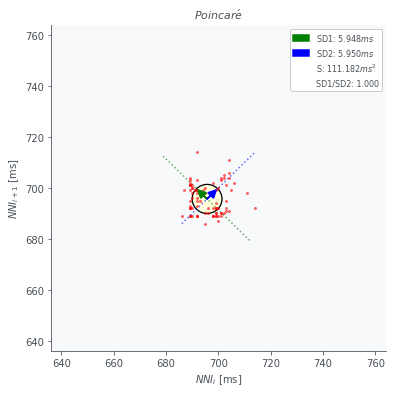

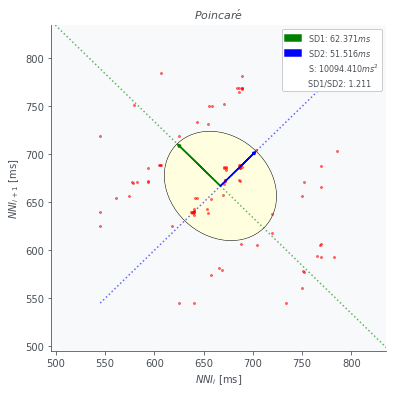

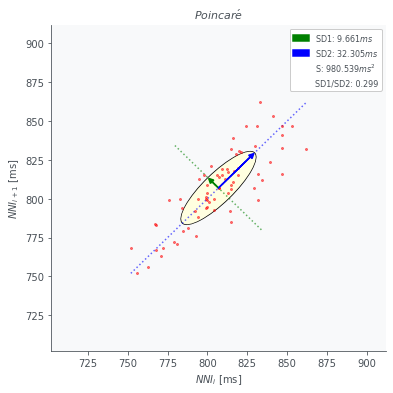

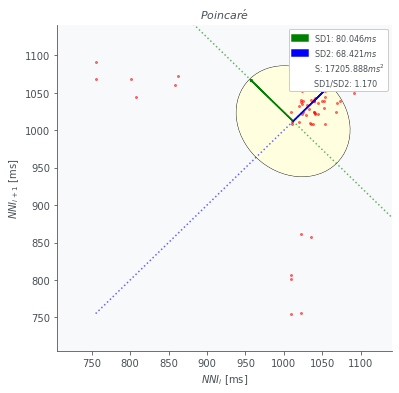

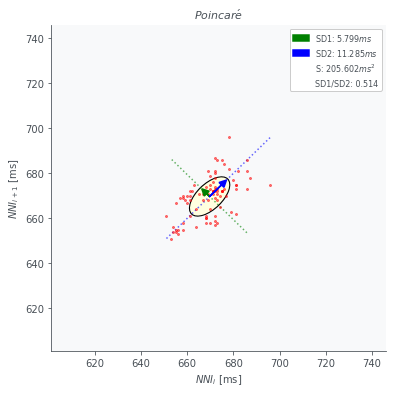

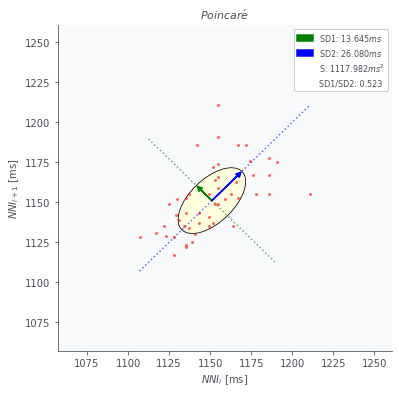

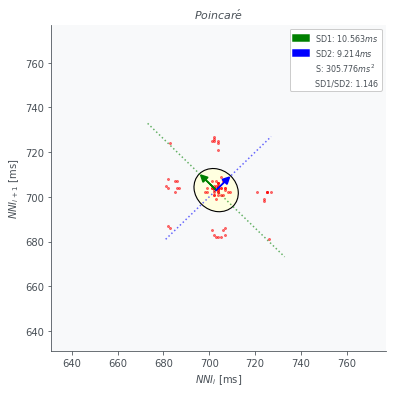

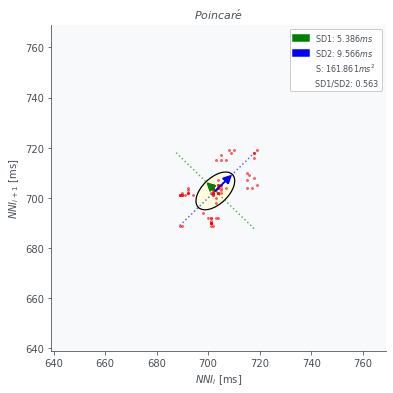

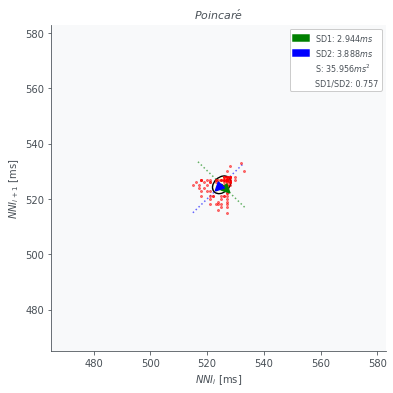

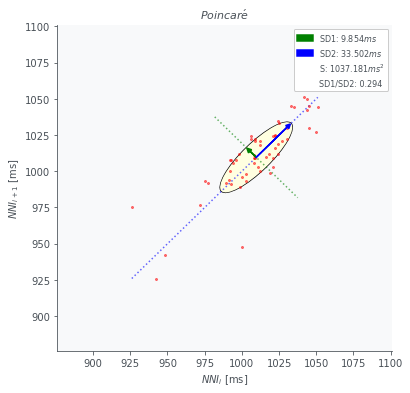

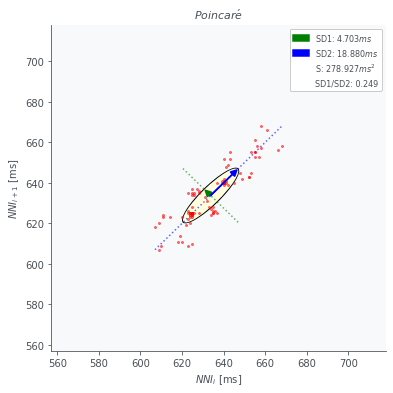

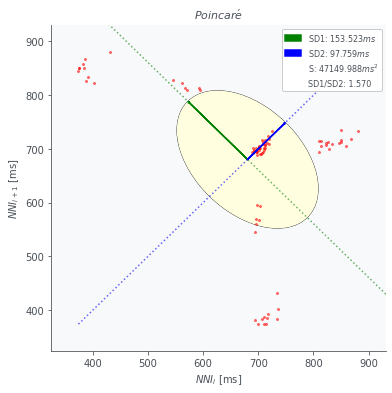

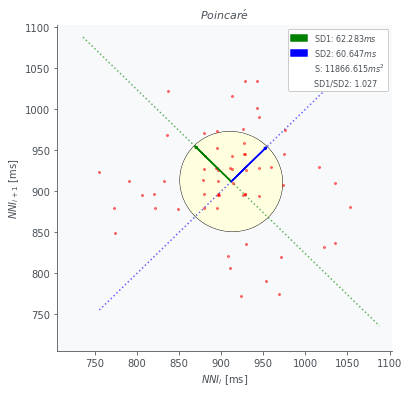

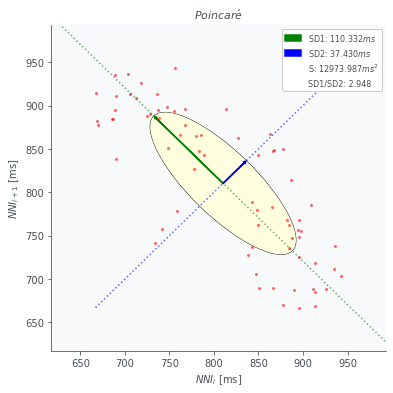

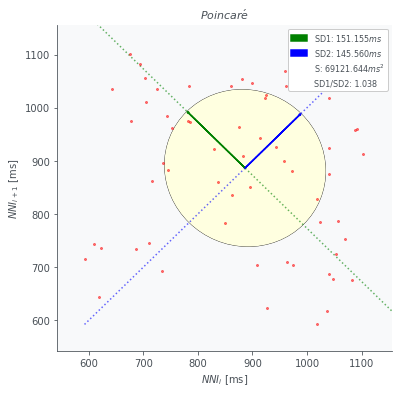

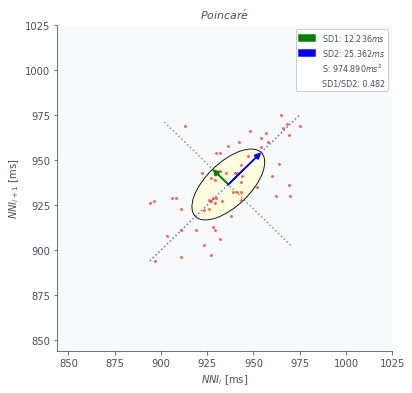

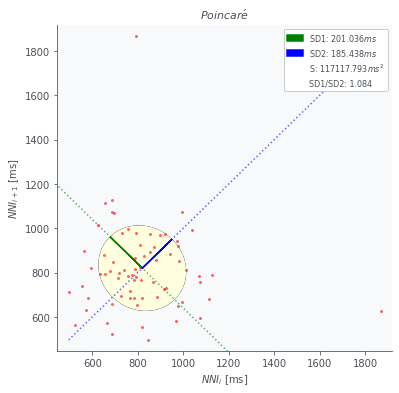

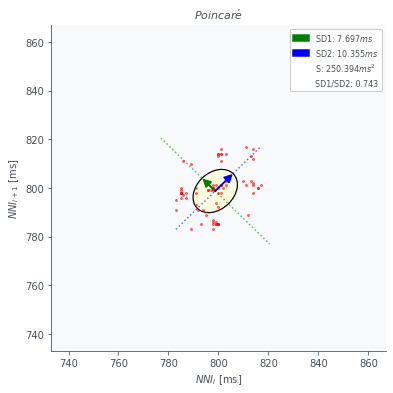

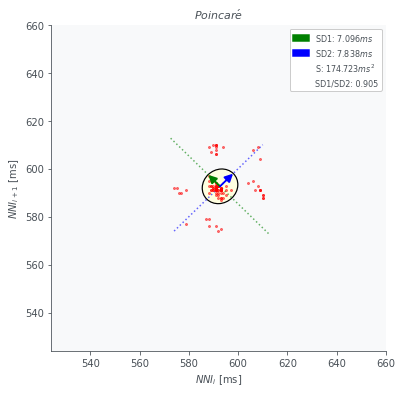

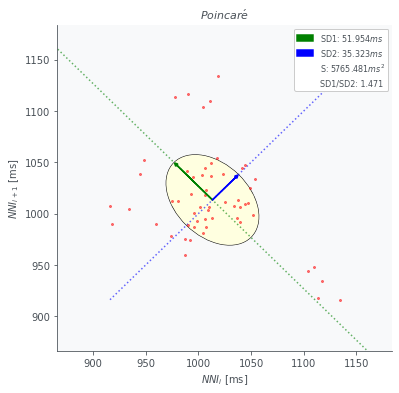

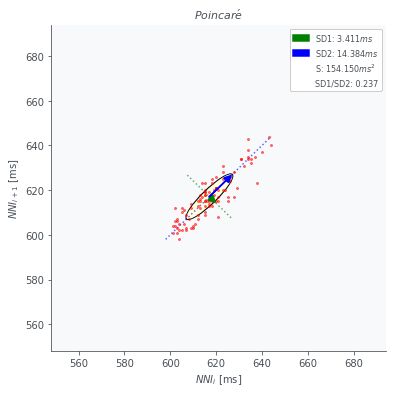

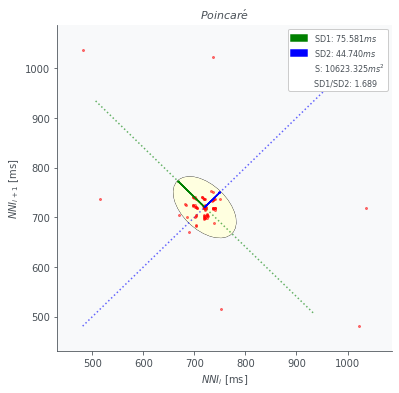

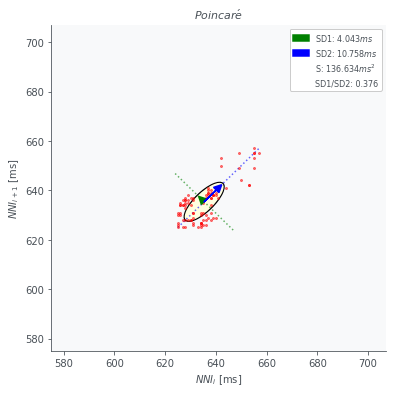

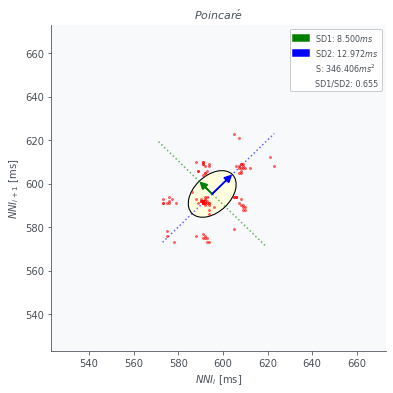

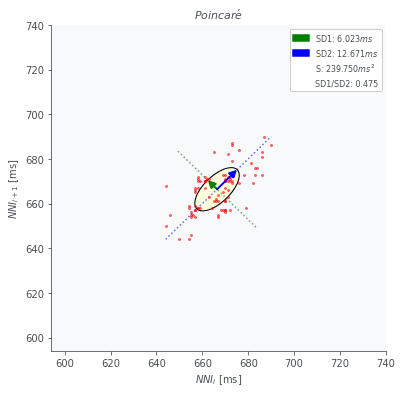

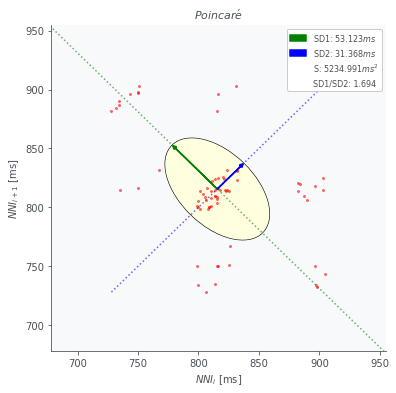

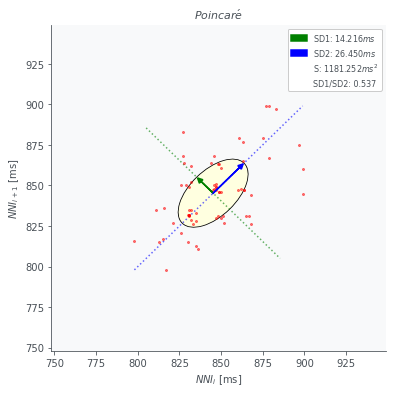

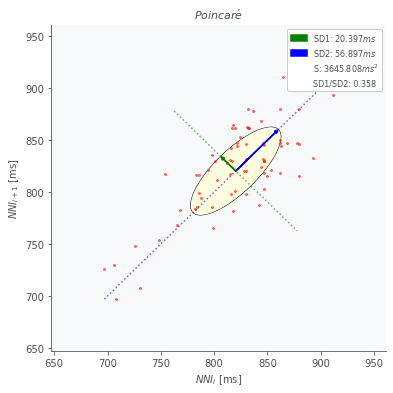

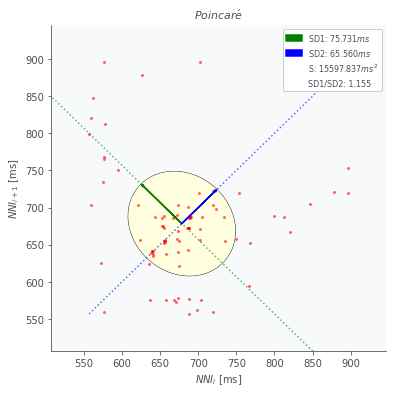

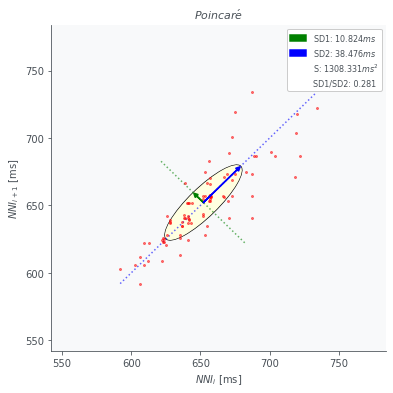

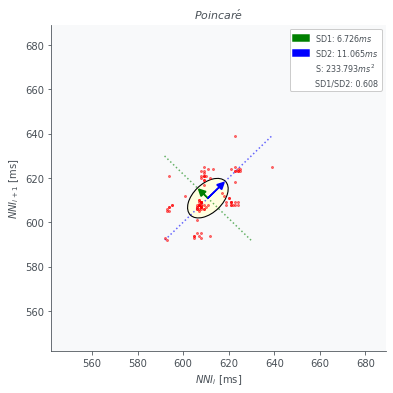

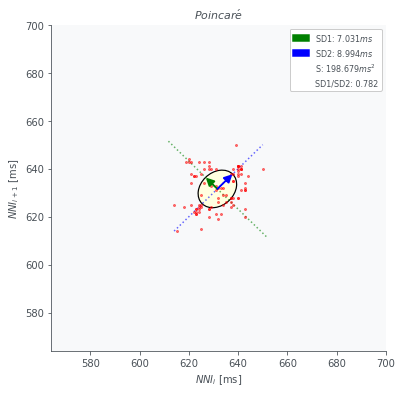

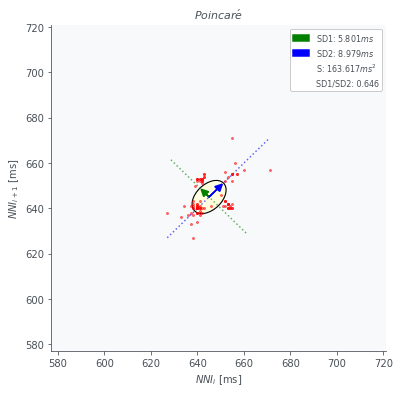

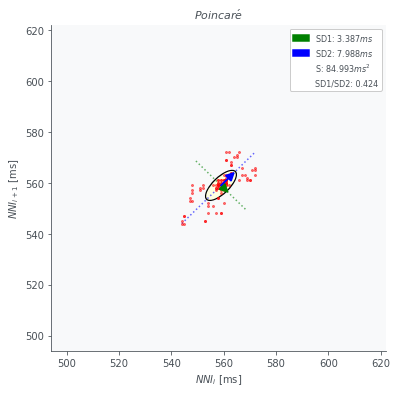

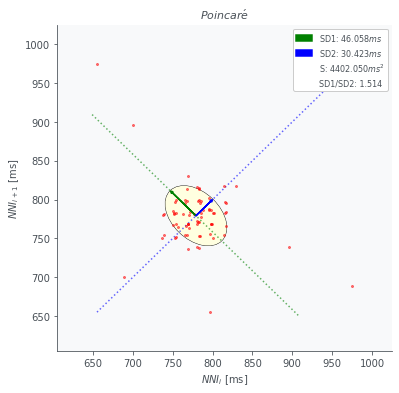

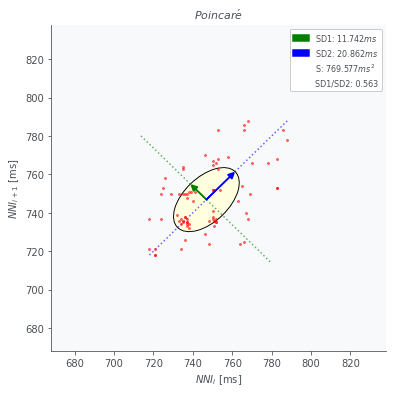

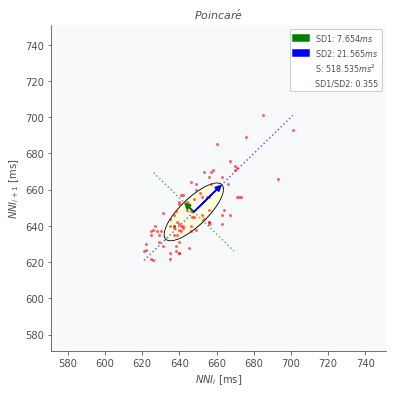

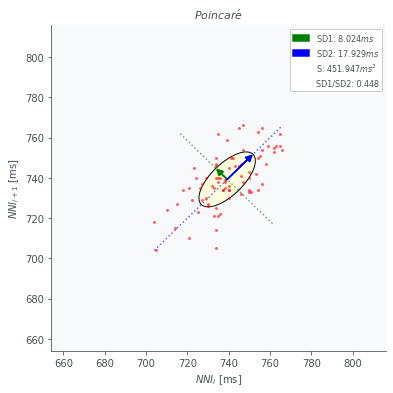

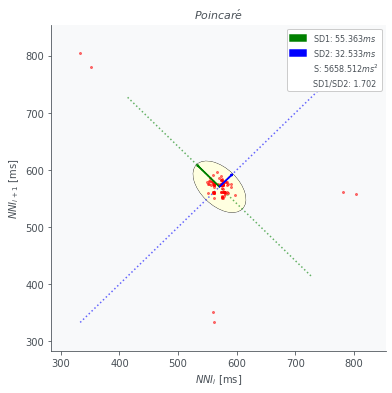

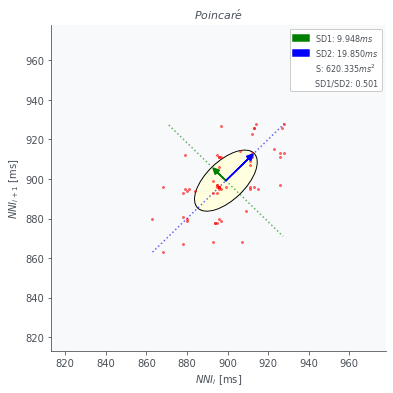

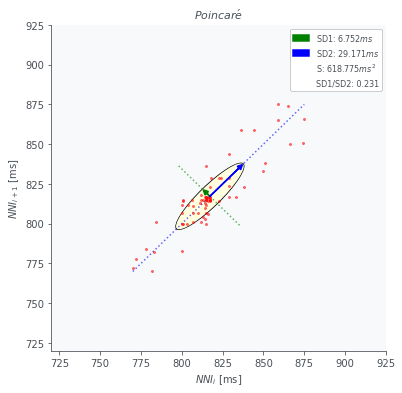

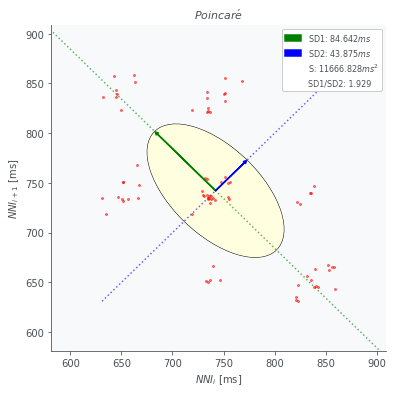

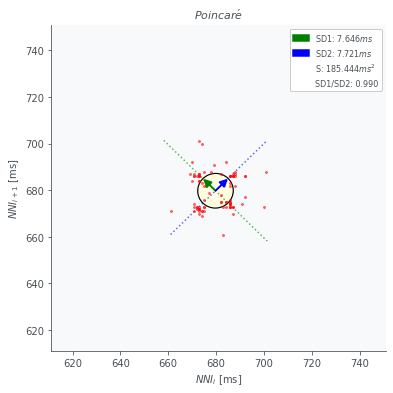

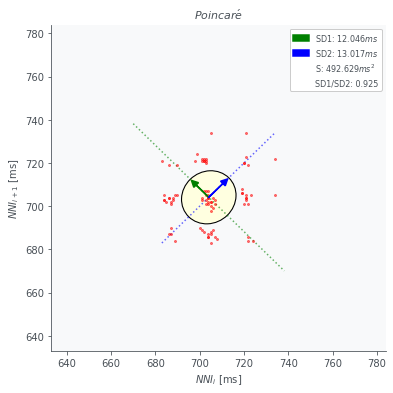

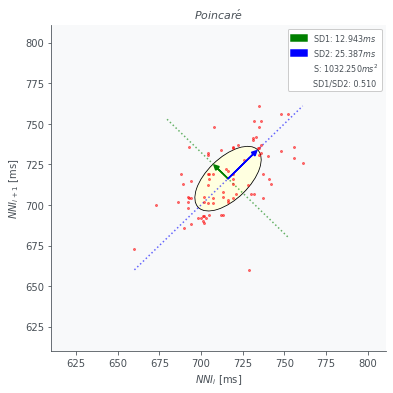

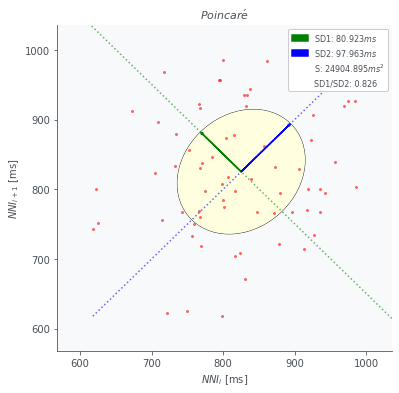

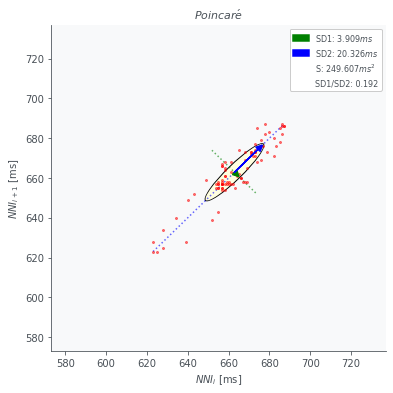

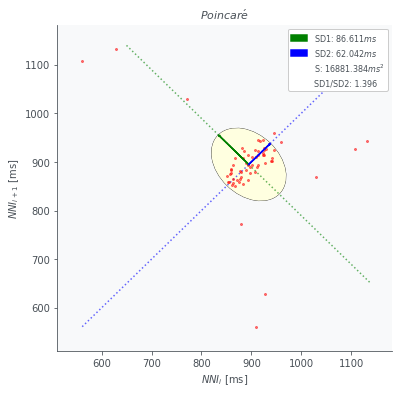

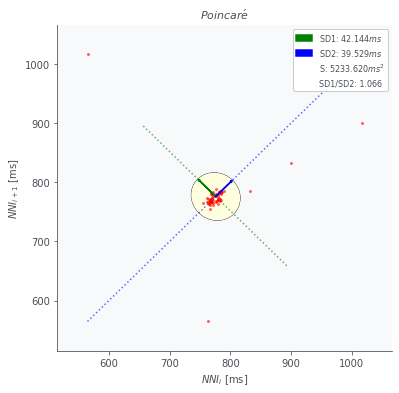

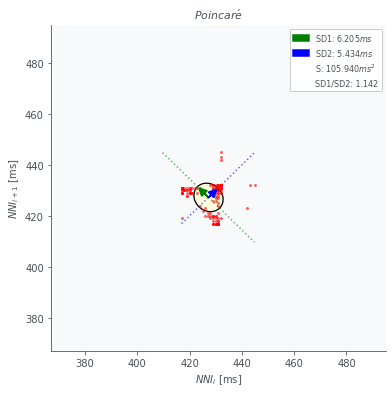

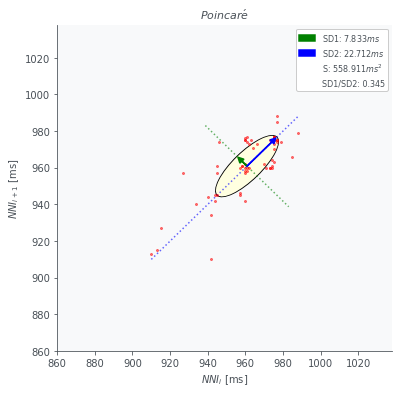

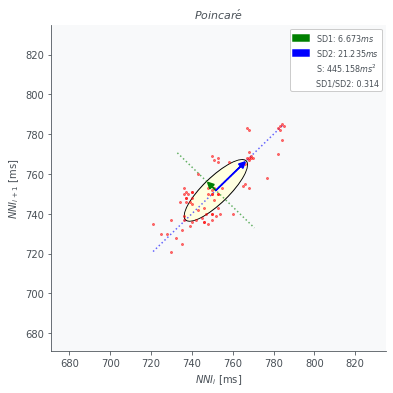

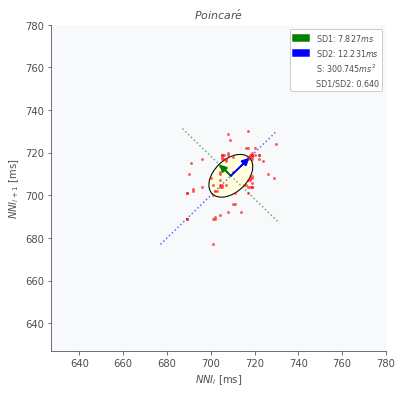

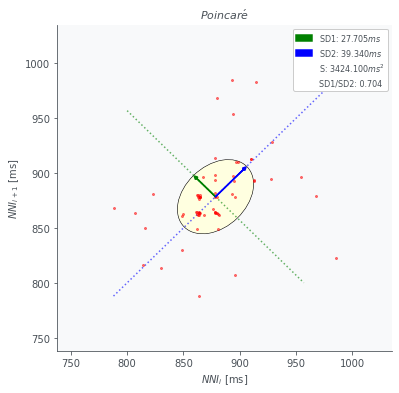

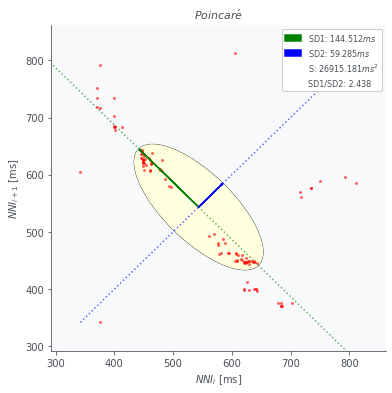

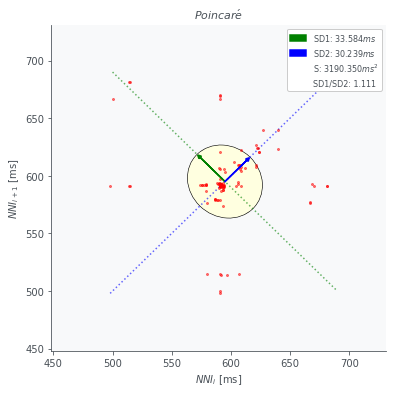

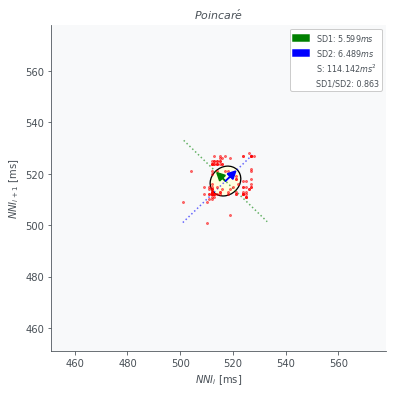

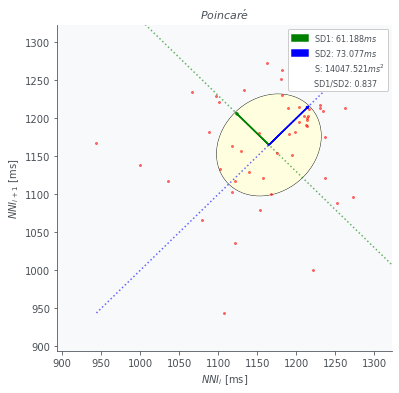

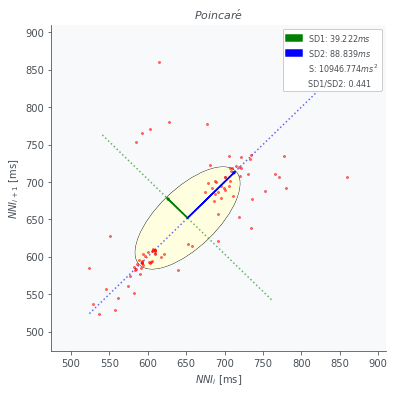

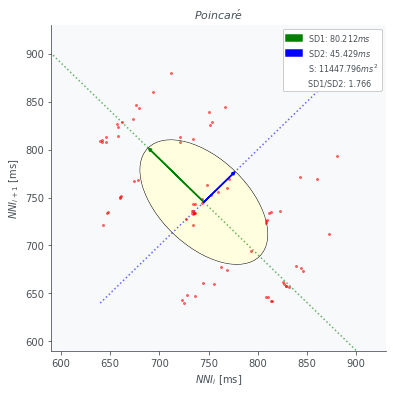

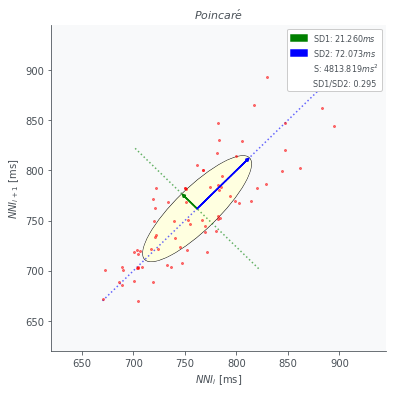

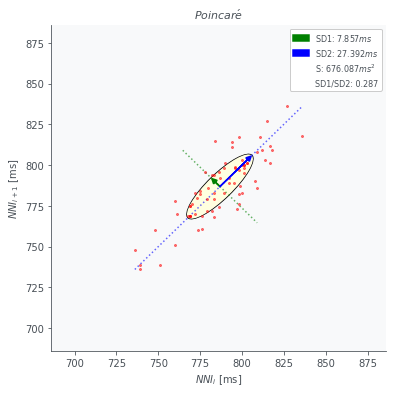

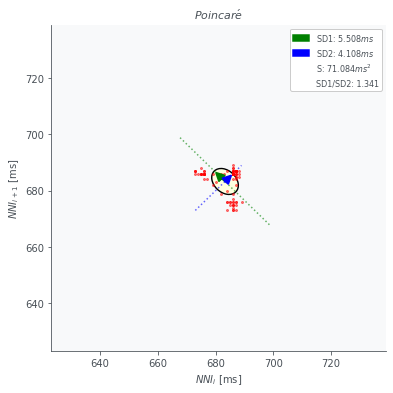

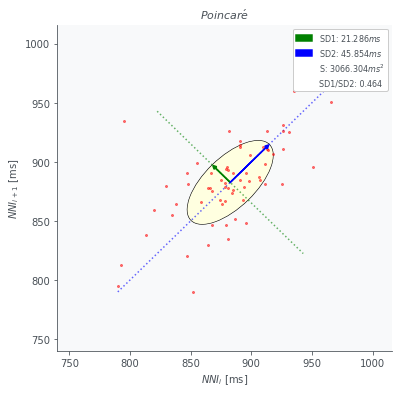

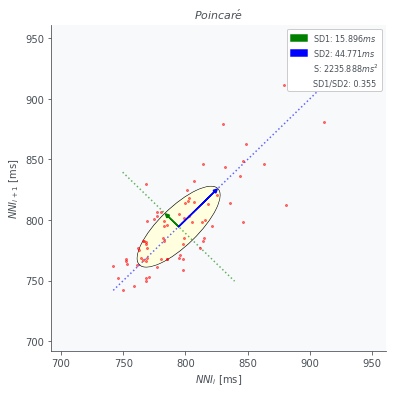

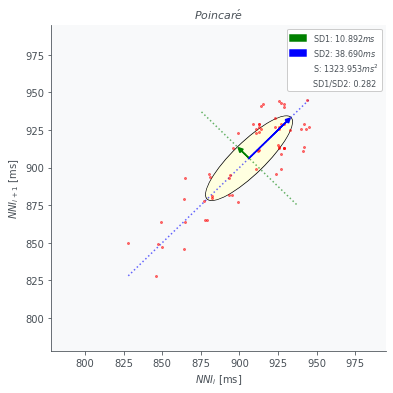

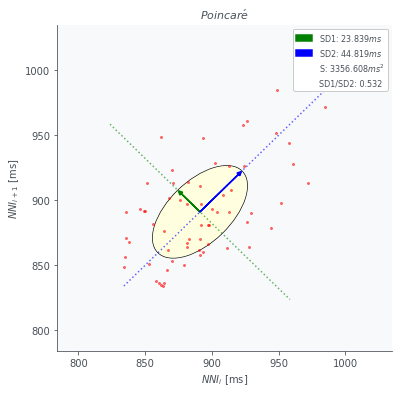

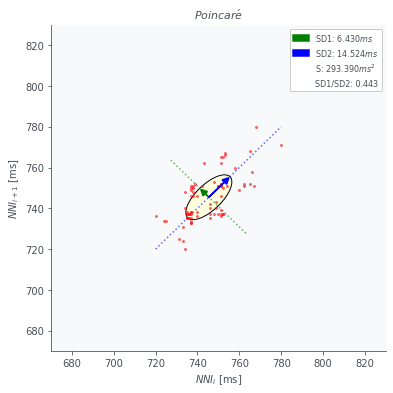

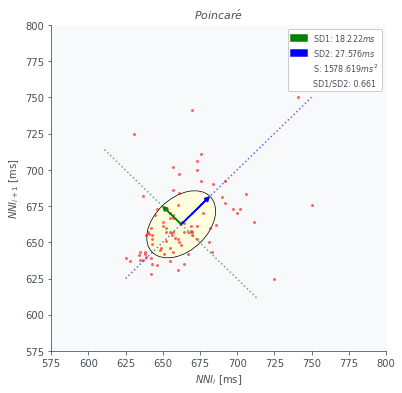

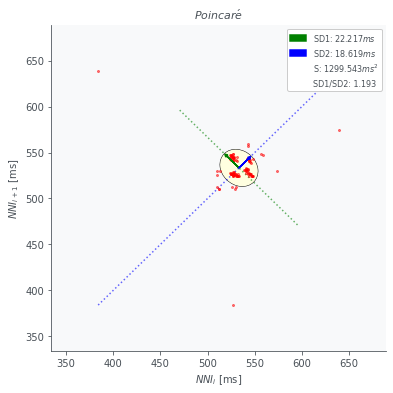

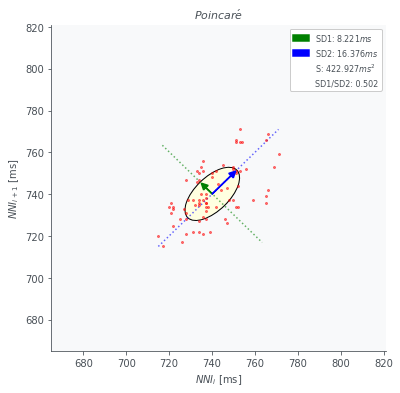

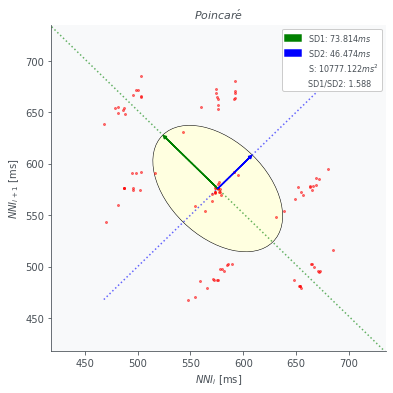

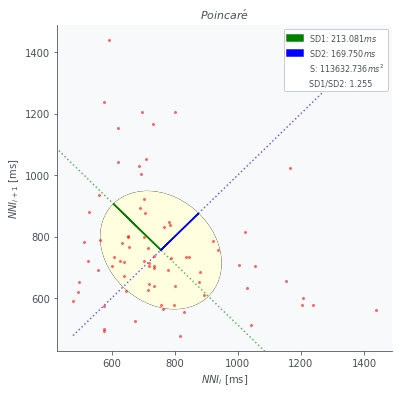

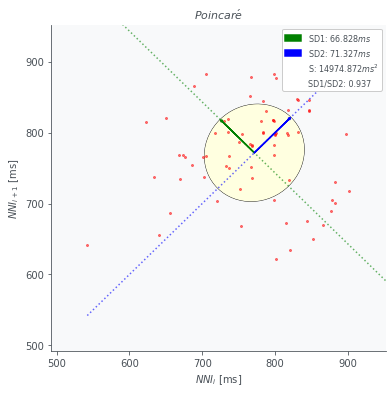

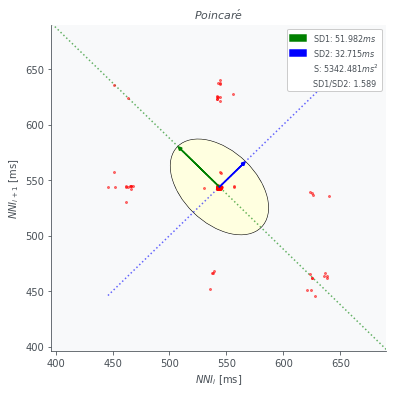

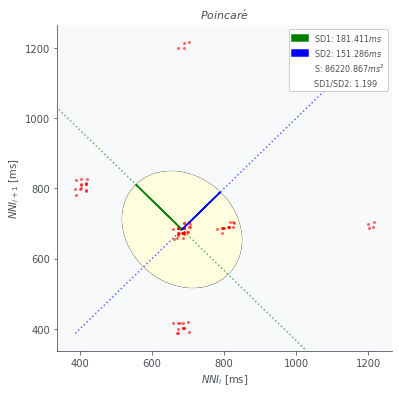

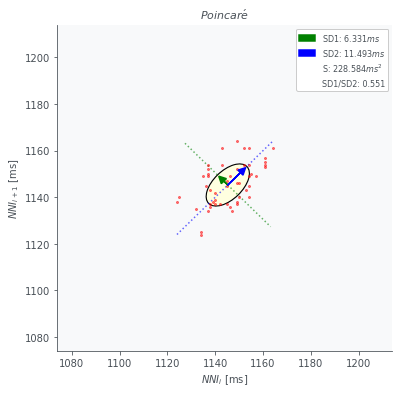

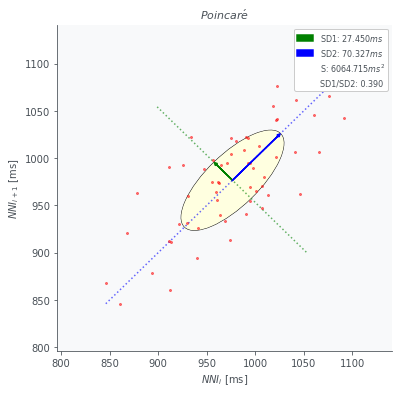

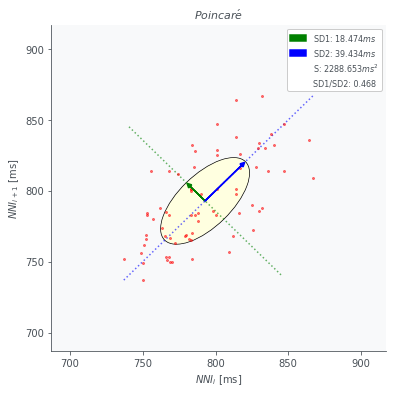

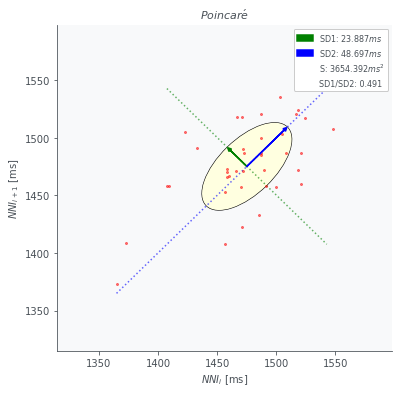

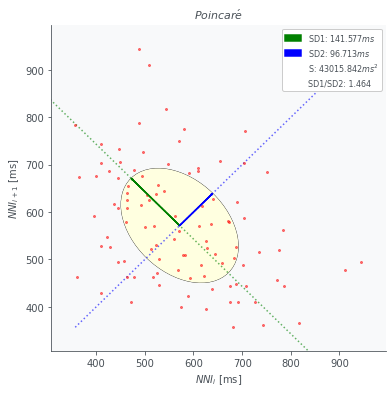

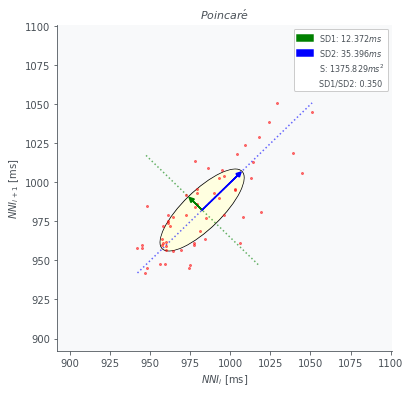

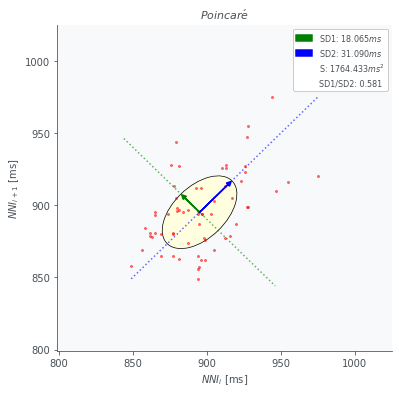

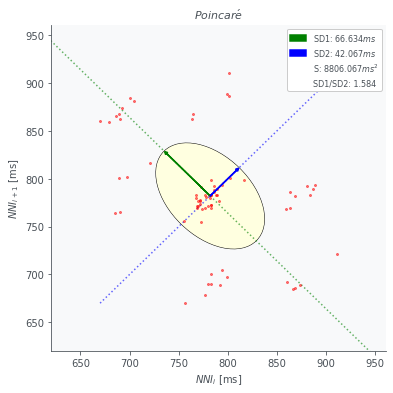

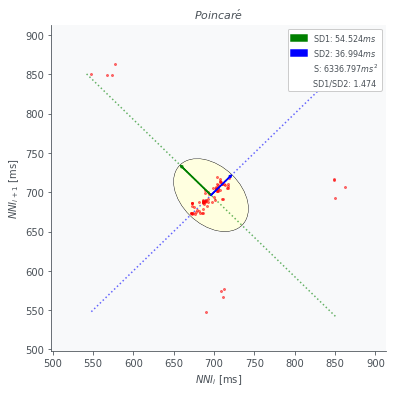

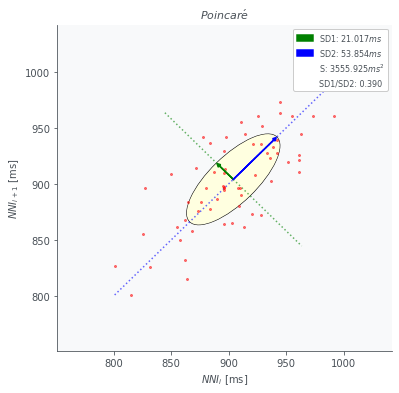

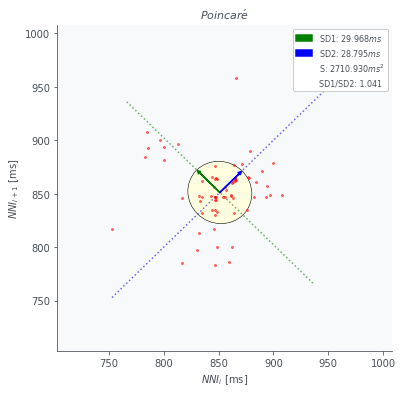

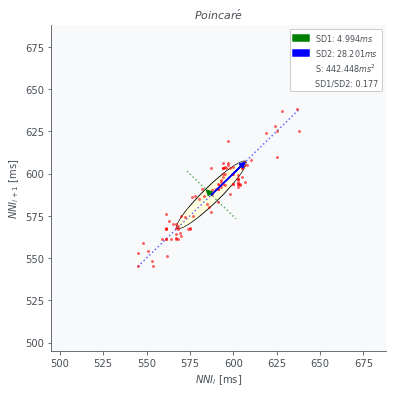

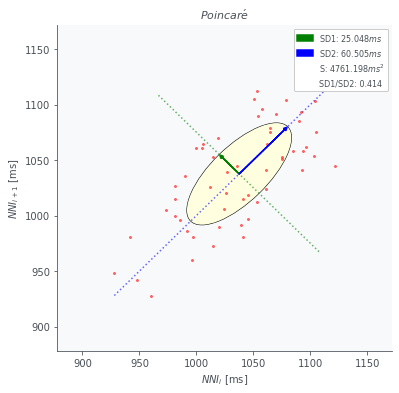

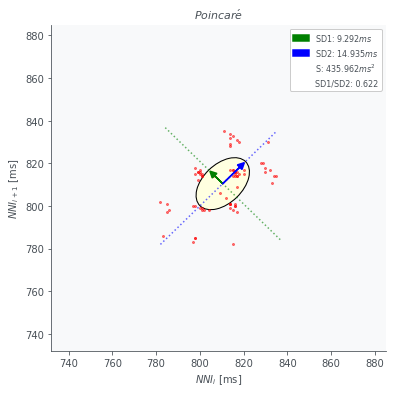

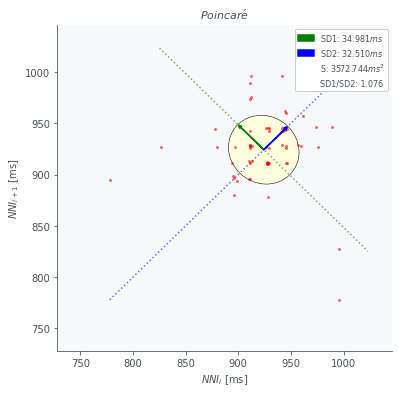

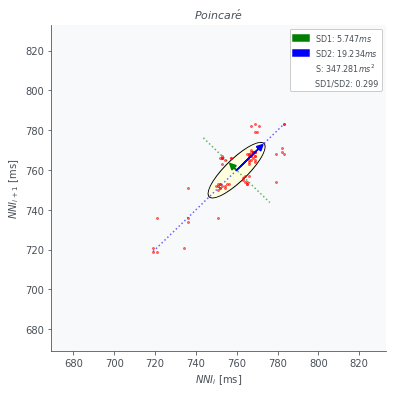

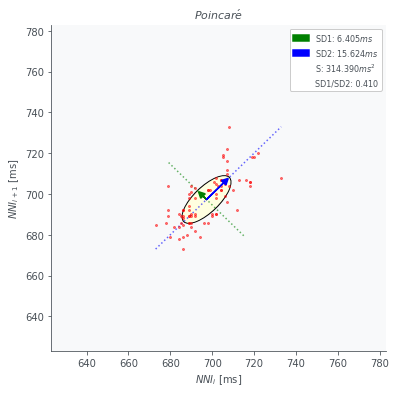

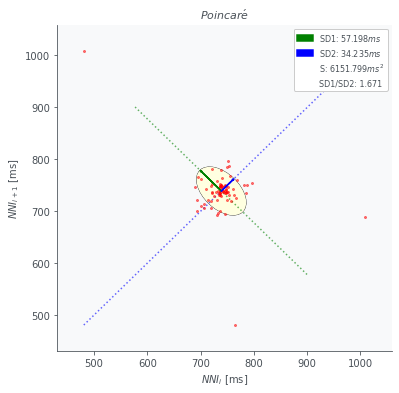

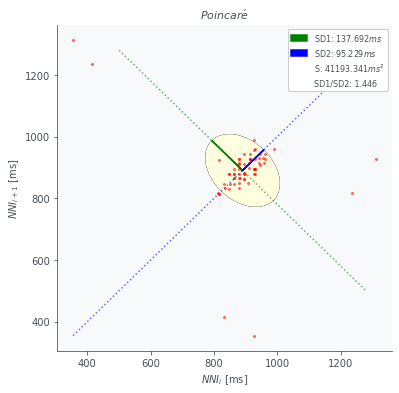

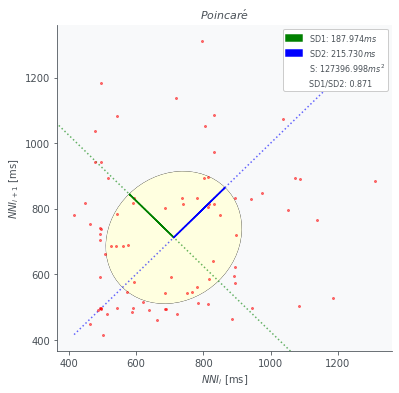

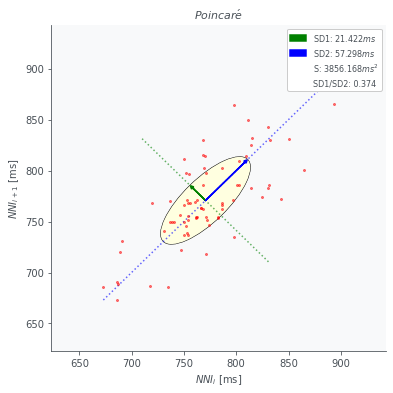

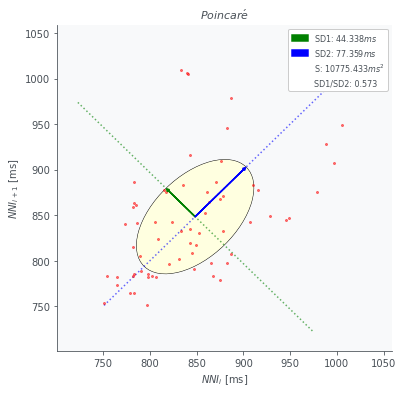

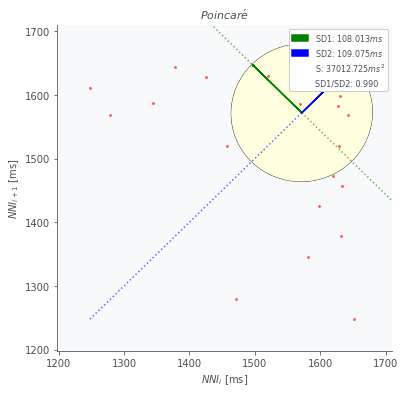

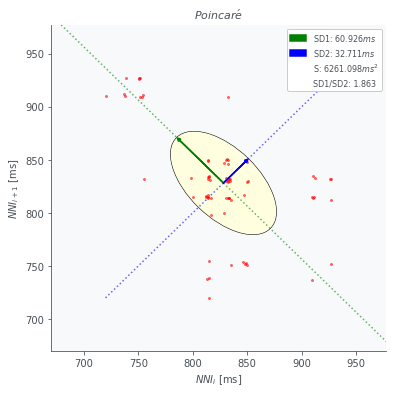

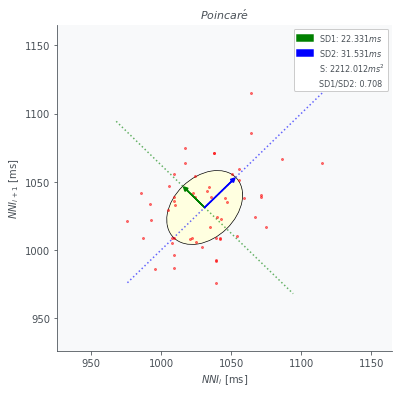

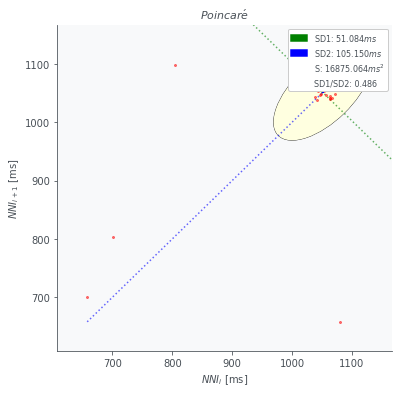

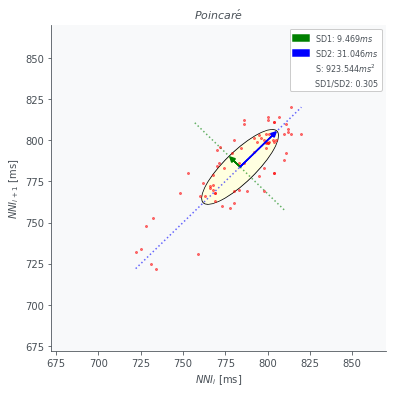

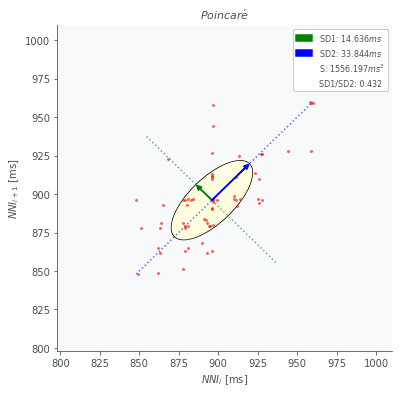

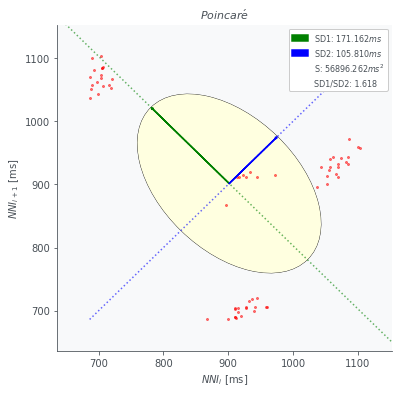

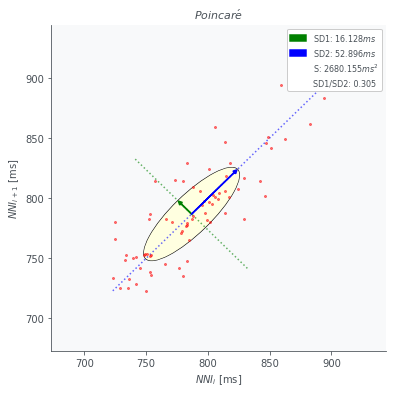

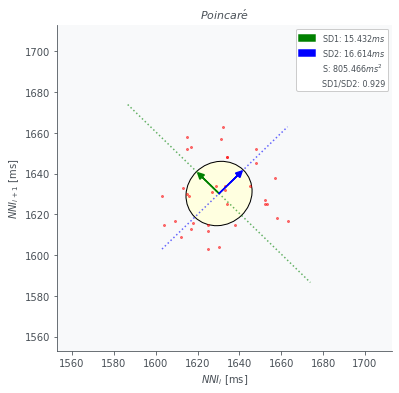

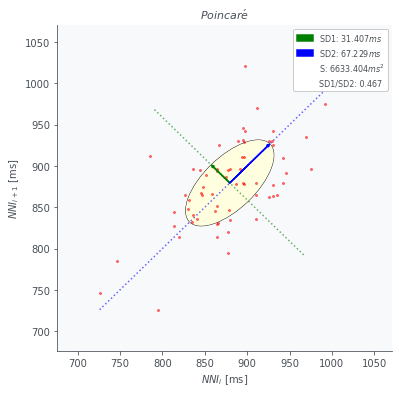

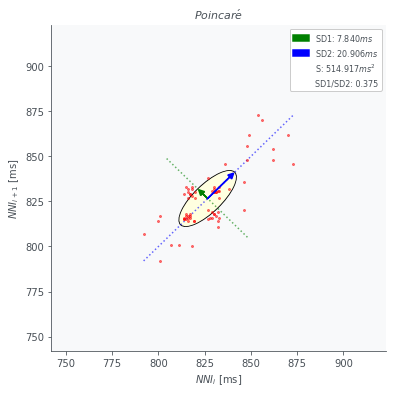

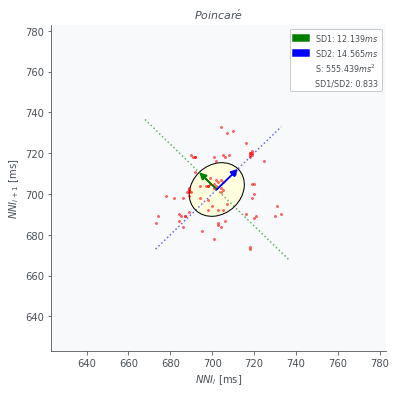

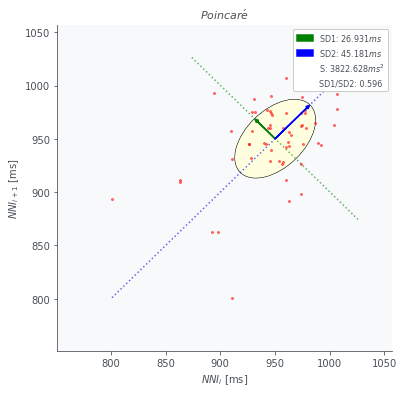

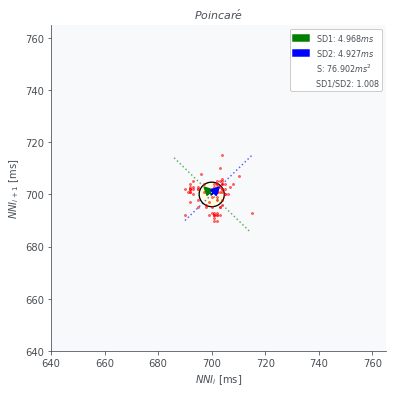

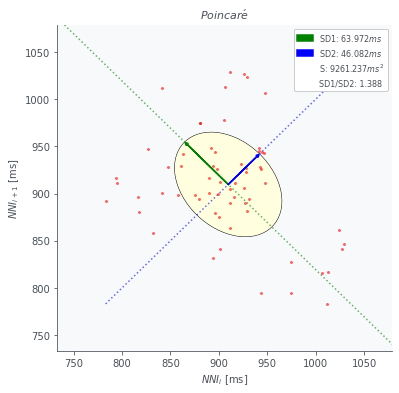

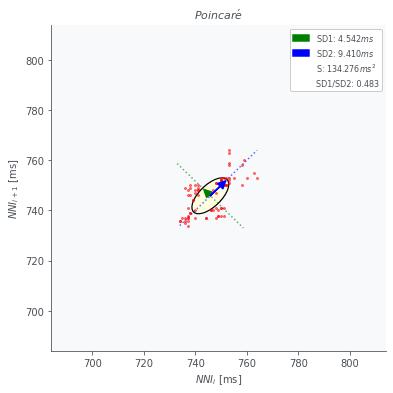

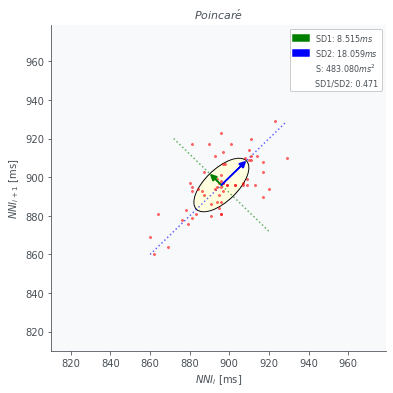

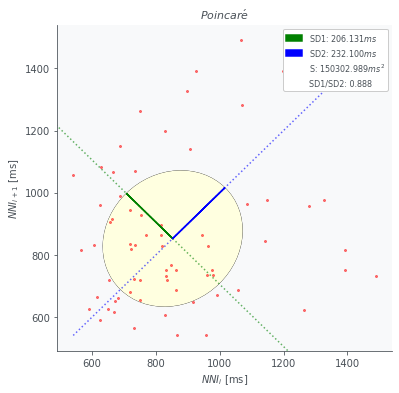

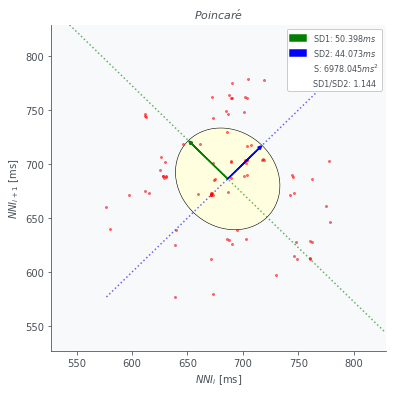

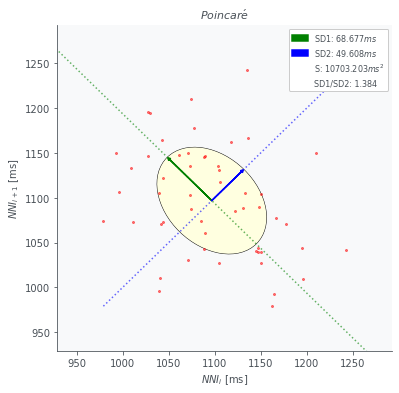

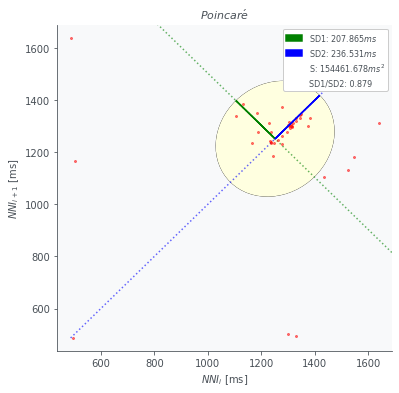

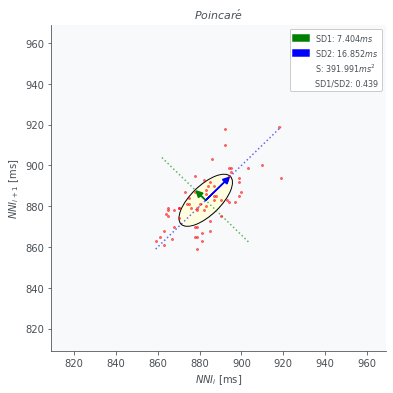

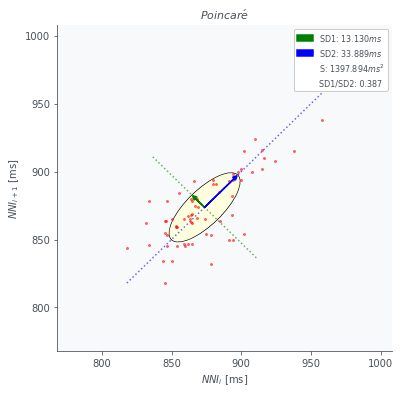

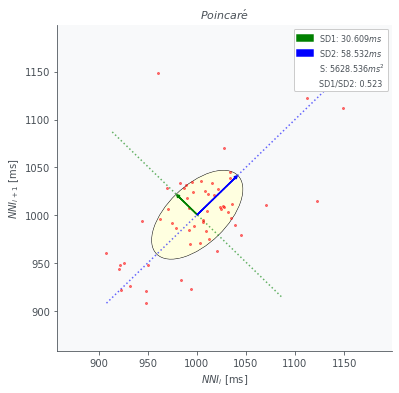

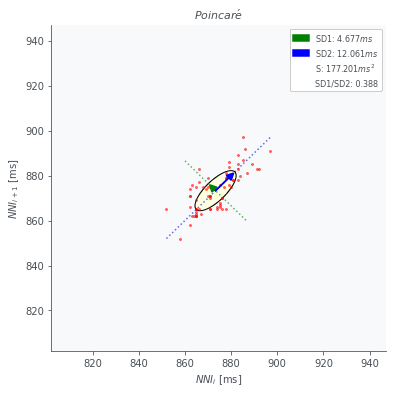

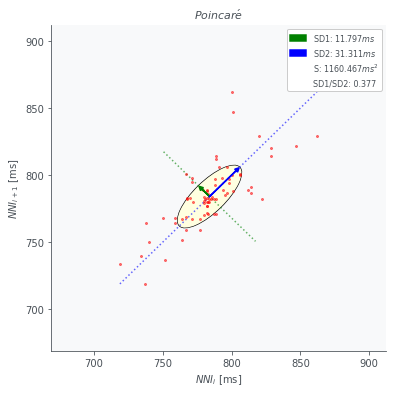

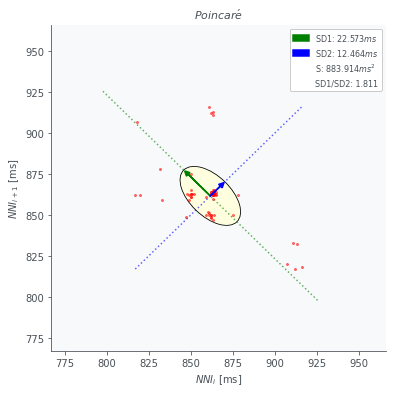

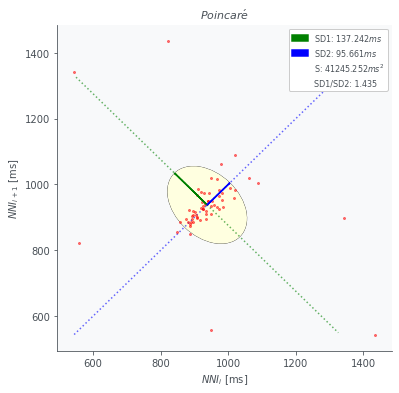

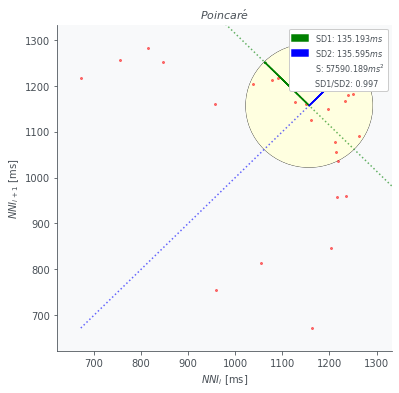

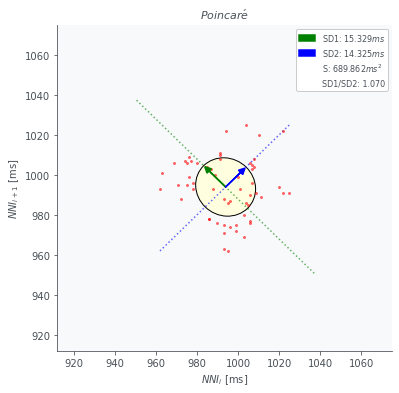

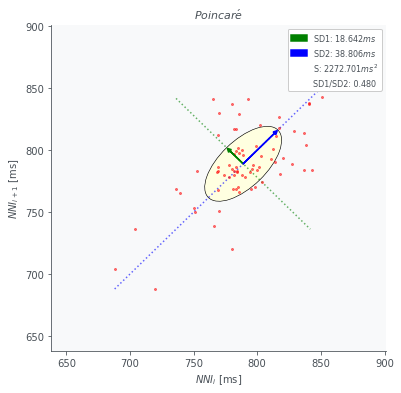

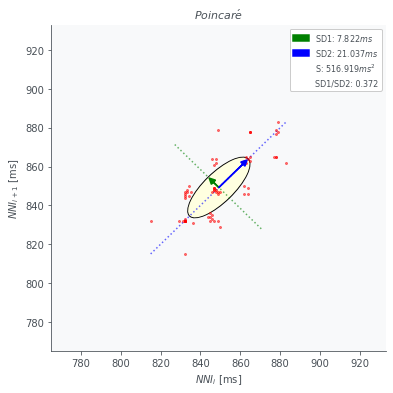

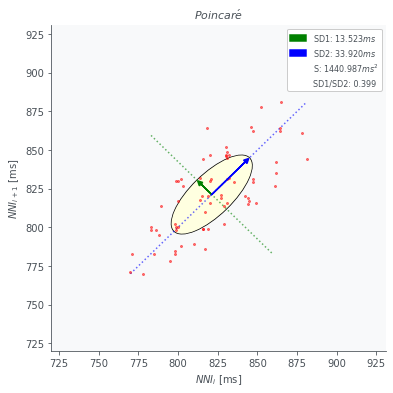

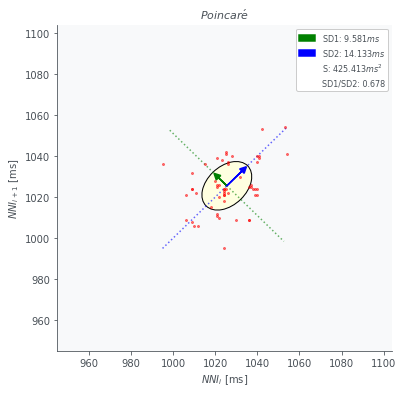

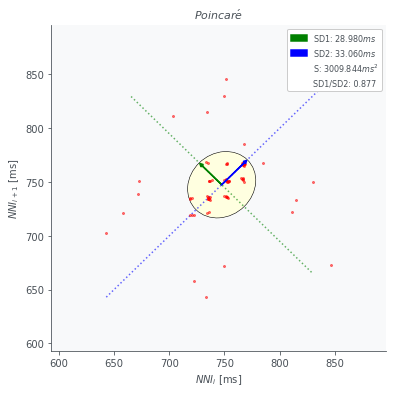

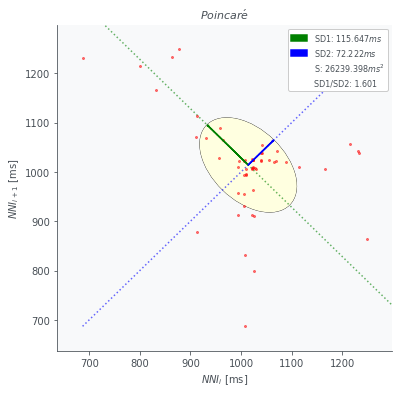

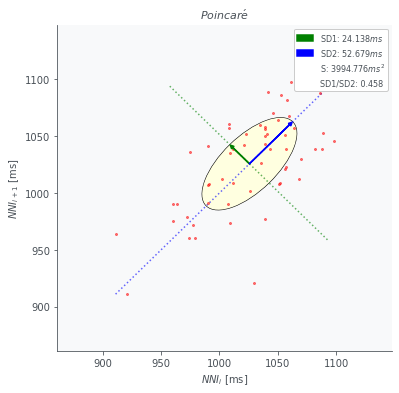

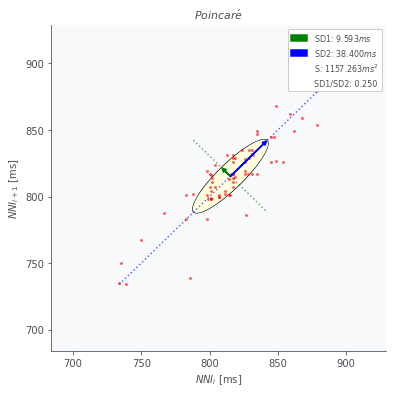

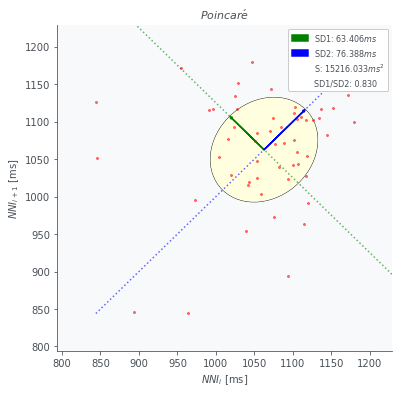

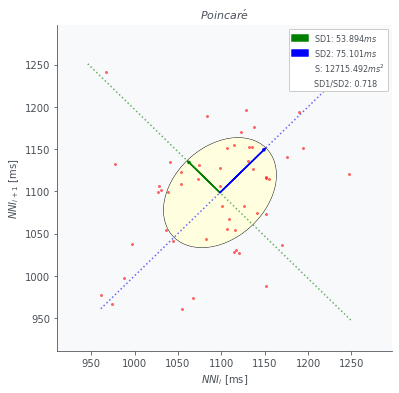

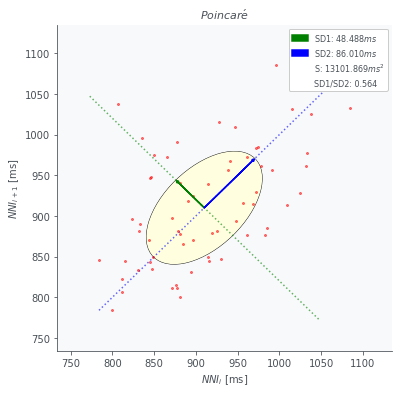

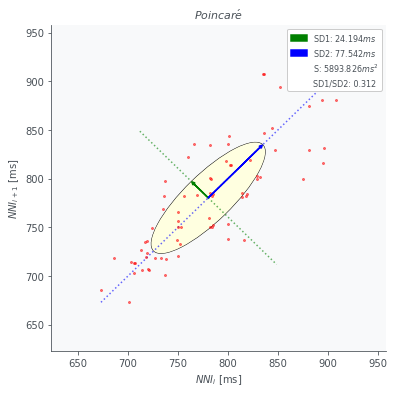

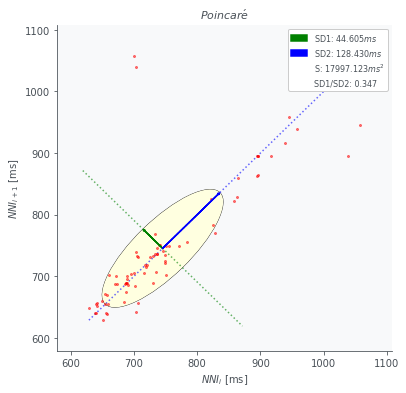

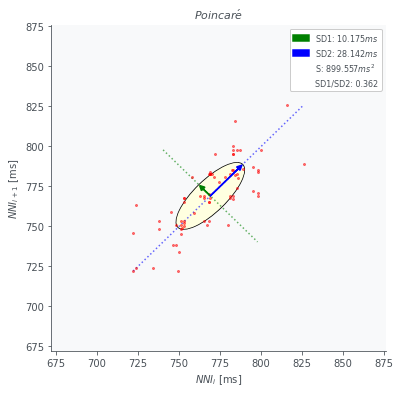

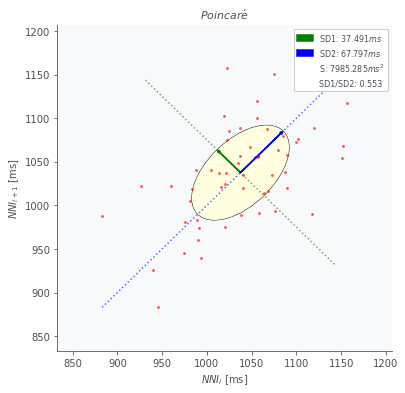

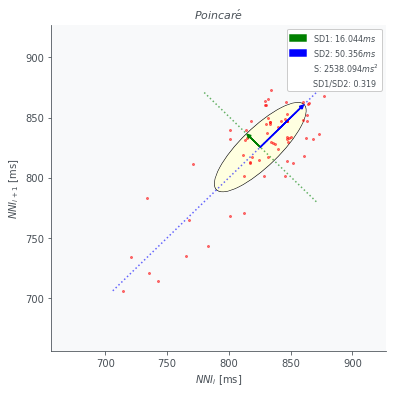

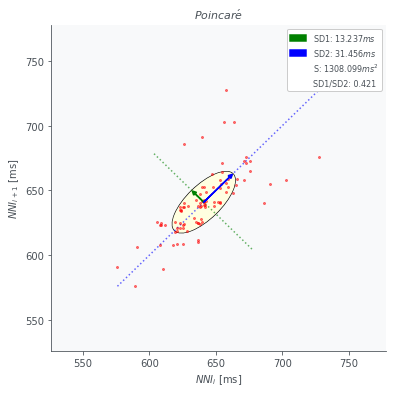

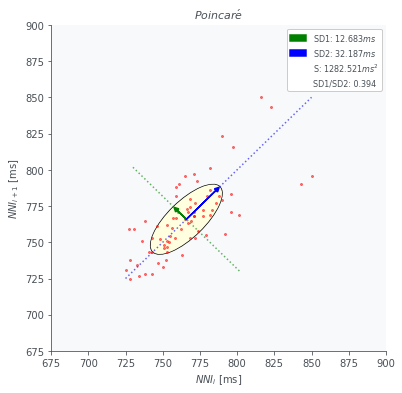

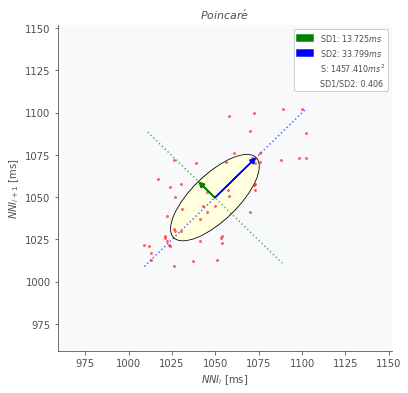

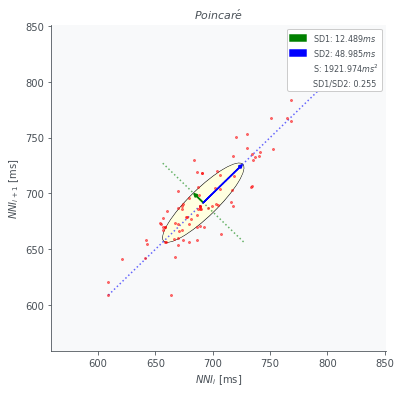

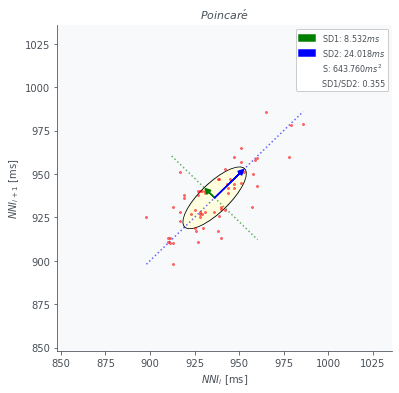

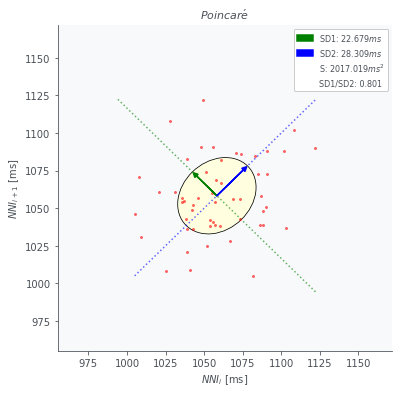

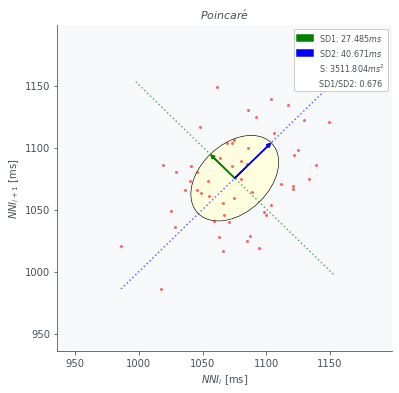

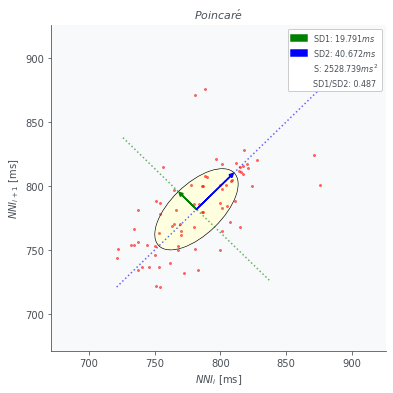

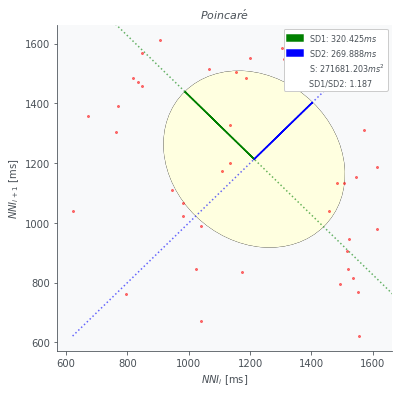

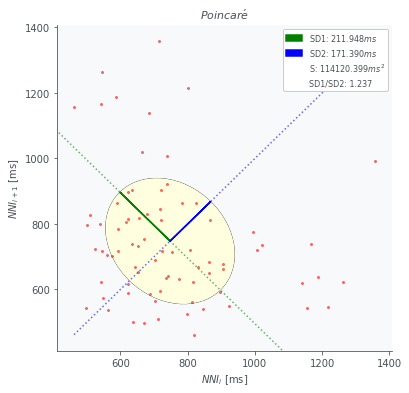

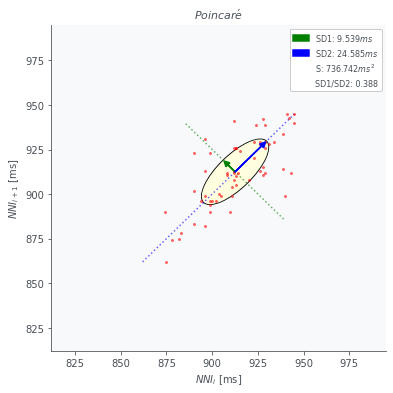

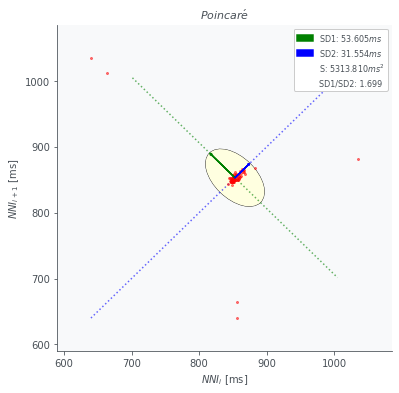

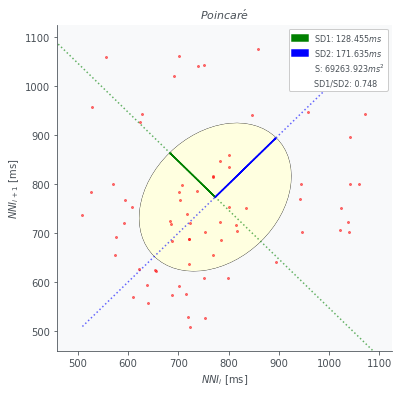

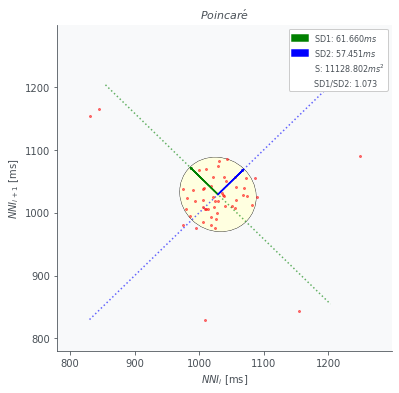

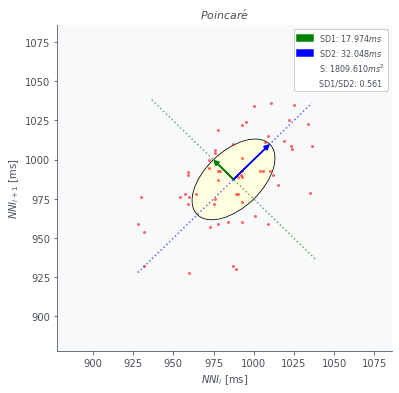

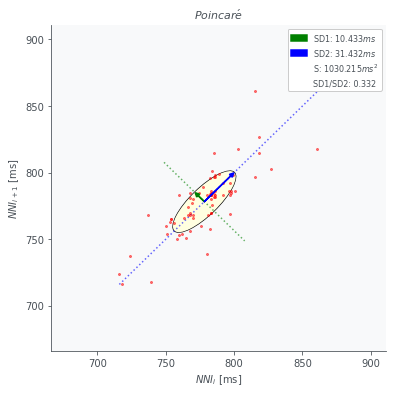

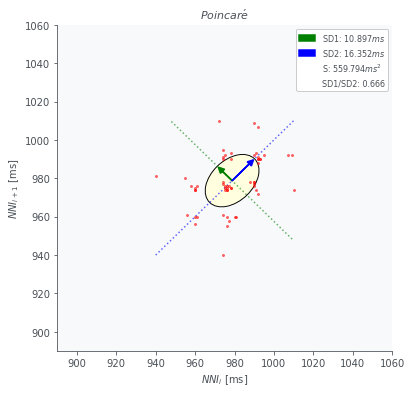

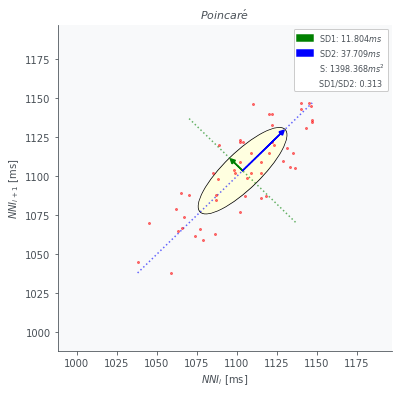

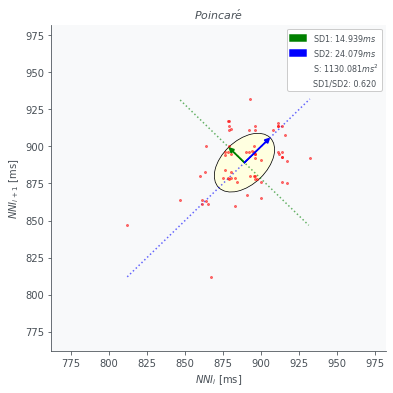

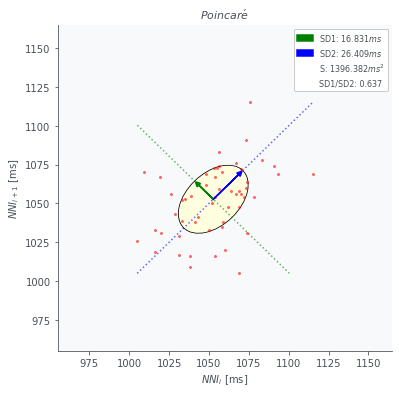

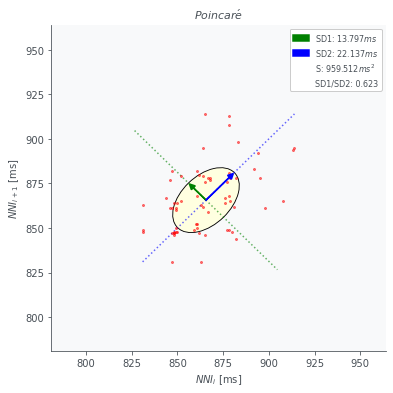

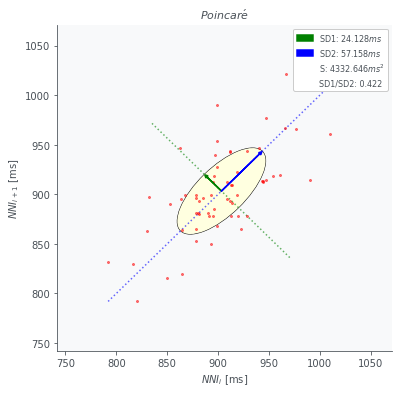

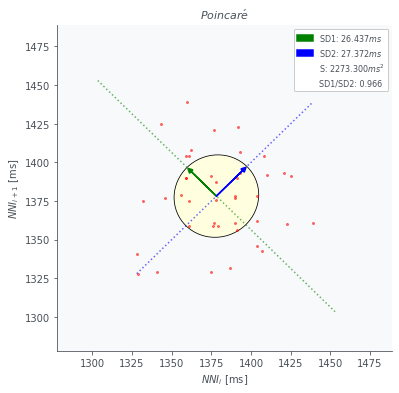

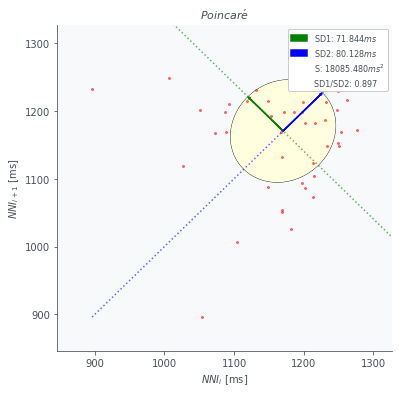

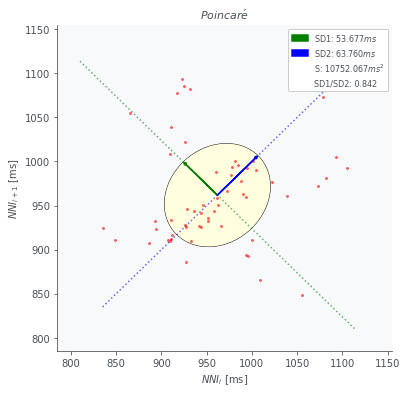

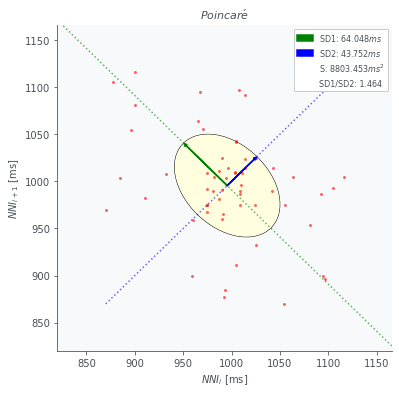

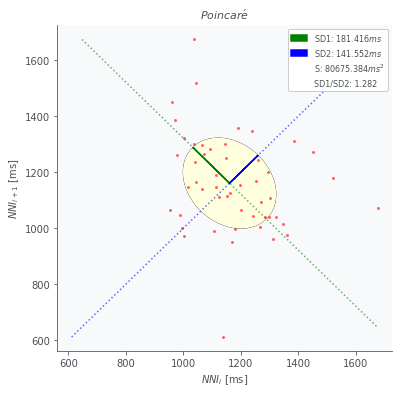

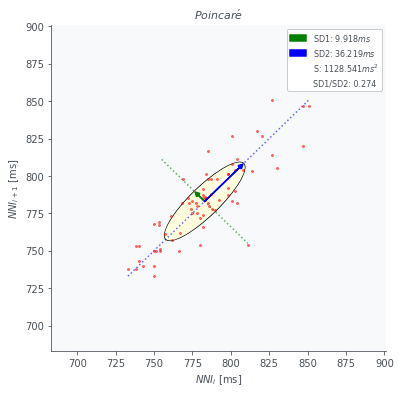

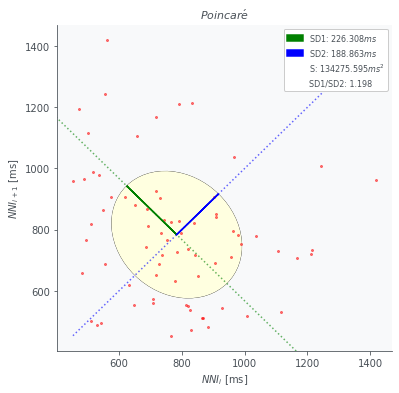

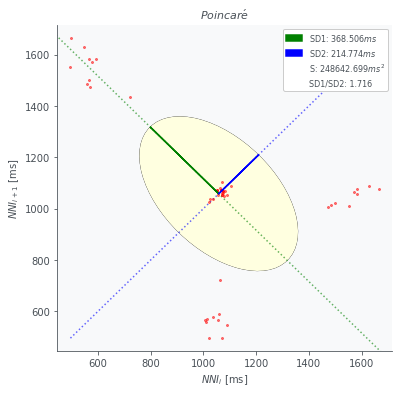

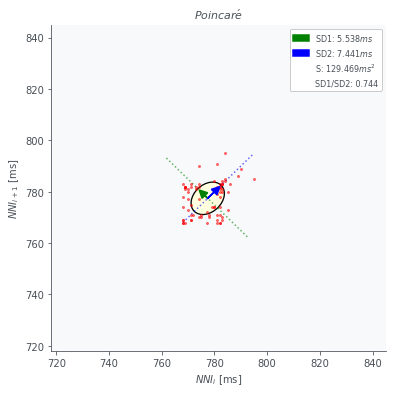

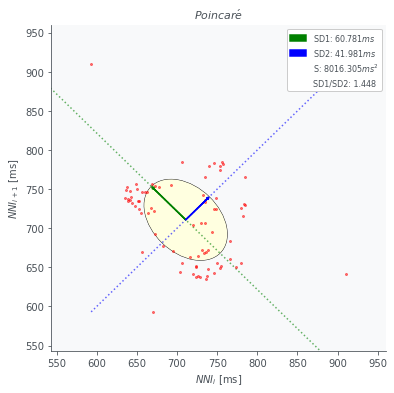

In [767]:
import pyhrv.nonlinear as nl

py_sd1s = np.zeros(shape = len(signal_health_state))
py_sd2s = np.zeros(shape = len(signal_health_state))
sd_ratio = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
        rpeaks =t[rpeaks]

        nl_features = nl.poincare(rpeaks=rpeaks, show=False)
        py_sd1s[i] = nl_features['sd1']
        py_sd2s[i] = nl_features['sd2']
        sd_ratio[i] = nl_features['sd_ratio']
        i+=1

In [768]:
print_averages(py_sd1s, 'sd1s', test_nan_indices)
print_averages(py_sd2s, 'sd2s', test_nan_indices)
print_averages(py_ratios, 'sd ratios', test_nan_indices)

Unhealthy sd1s: mean:49.6785049842318, std: 65.63428586252742
Healthy sd1s: mean:31.549664515081986, std:33.32868003904171
Unhealthy sd2s: mean:49.13943236349029, std: 53.02353992377074
Healthy sd2s: mean:52.9725919966187, std:26.65430673322035
Unhealthy sd ratios: mean:1.8162190667335716, std: 3.236743895191154
Healthy sd ratios: mean:3.0115525420552554, std:4.23137327384377


### Sample Entropy
quantifies the unpredictability of fluctuations in the data set

In [769]:
def calculate_sample_entropy(signal, m=2, r=0.2):
    rr_intervals = get_rri(signal)[0]
    N = len(rr_intervals)
    r *= np.std(rr_intervals)  # tolerance r is usually set as a fraction of the standard deviation
    
    def _phi(m):
        X = np.array([rr_intervals[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(X[:, None] - X[None, :]), axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log((_phi(m + 1)) / (_phi(m)))

In [770]:
samp_en = calculate_sample_entropy(test_signal)
print("Sample Entropy:", samp_en)

Sample Entropy: 1.0033570278925557


In [771]:
samp_ens = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        samp_en = calculate_sample_entropy(signal)
        samp_ens[i] = samp_en
        i+=1

In [772]:
print_averages(samp_ens, 'sample entropy', test_nan_indices)

Unhealthy sample entropy: mean:1.3523864100536154, std: 0.6202085004905667
Healthy sample entropy: mean:1.5002557013609168, std:0.5154903834832769


In [773]:
py_samp_en = np.zeros(shape=len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        # Get R-peaks series using biosppy
        t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
        rpeaks =t[rpeaks]

        py_samp_en[i] = nl.sample_entropy(rpeaks = rpeaks)['sampen']
        i+=1


In [774]:
print_averages(py_samp_en, 'sample entropy', test_nan_indices)

Unhealthy sample entropy: mean:1.4180215624962653, std: 0.5643635067616987
Healthy sample entropy: mean:1.526775625258262, std:0.5796175268606263


### Shannon Entropy 
also known as information entropy, is a measure of the uncertainty or randomness in a set of values

In [775]:
def calculate_shannon_entropy(rr_intervals, num_bins=10):
    # discretize RR intervals into bins and calculate probabilities
    hist, bin_edges = np.histogram(rr_intervals, bins=num_bins, density=True)
    
    probabilities = hist / np.sum(hist)
    
    # Calculate Shannon Entropy using equation
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))  # adding a small value to avoid log(0)
    
    return shannon_entropy

In [776]:
shannon_en = calculate_shannon_entropy(rr_intervals)
print('Shannon Entropy:', shannon_en)

Shannon Entropy: 1.1095603438170536


In [777]:
shannon_ens = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        shannon_en = calculate_shannon_entropy(signal)
        shannon_ens[i] = shannon_en
        i+=1

In [778]:
print_averages(shannon_ens, 'shannon entropy', test_nan_indices)

Unhealthy shannon entropy: mean:1.6080777151791041, std: 0.32641388259521775
Healthy shannon entropy: mean:1.5718560886697108, std:0.3229535026183892


In [779]:
peaks, info = nk.ecg_peaks(test_signal, sampling_rate=1000)
nl_indices = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)
print(nl_indices.columns)

Index(['HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI',
       'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS',
       'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a',
       'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a',
       'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1',
       'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak',
       'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max',
       'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry',
       'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Increment',
       'HRV_ApEn', 'HRV_SampEn', 'HRV_ShanEn', 'HRV_FuzzyEn', 'HRV_MSEn',
       'HRV_CMSEn', 'HRV_RCMSEn', 'HRV_CD', 'HRV_HFD', 'HRV_KFD', 'HRV_LZC'],
      dtype='object')


In [780]:
nk_sd1s = np.zeros(shape=len(signal_health_state))
nk_sd2s = np.zeros(shape = len(signal_health_state))
nk_sd_ratios = np.zeros(shape = len(signal_health_state))
nk_shannons = np.zeros(shape = len(signal_health_state))
nk_sampens = np.zeros(shape = len(signal_health_state))
nk_fuzzys = np.zeros(shape = len(signal_health_state))
i=0
for signal in denoised_signals_one_channel:
    if not np.isnan(signal).all():
        peaks, info = nk.ecg_peaks(signal, sampling_rate=1000)
        nl_indices = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=False)
        nk_sd1s[i] = nl_indices['HRV_SD1']
        nk_sd2s[i] = nl_indices['HRV_SD2']
        nk_sd_ratios[i] = nl_indices['HRV_SD1SD2']
        nk_shannons[i] = nl_indices['HRV_ShanEn']
        nk_sampens[i] = nl_indices['HRV_SampEn']
        nk_fuzzys[i] = nl_indices['HRV_FuzzyEn']
        i+=1
    

In [781]:
print_averages(nk_sd1s, 'sd1s', test_nan_indices)
print_averages(nk_sd2s, 'sd2s', test_nan_indices)
print_averages(nk_sd_ratios, 'sd ratios', test_nan_indices)
print_averages(nk_shannons, 'shannon en', test_nan_indices)
print_averages(nk_sampens, 'samp en', test_nan_indices)
print_averages(nk_fuzzys, 'fuzzy en', test_nan_indices)

Unhealthy sd1s: mean:64.77630809132954, std: 100.97891710667302
Healthy sd1s: mean:31.744668161279723, std:32.21822601374412
Unhealthy sd2s: mean:62.02959584236889, std: 90.2350312238491
Healthy sd2s: mean:53.43578549236611, std:26.779663313575384
Unhealthy sd ratios: mean:0.9164410980772435, std: 0.5039833349734014
Healthy sd ratios: mean:0.5455185956230636, std:0.3120463794165342
Unhealthy shannon en: mean:4.741247111285494, std: 0.7762334495326861
Healthy shannon en: mean:5.252368052722374, std:0.30974007386507946
Unhealthy samp en: mean:1.3315693222388472, std: 0.6063419301946528
Healthy samp en: mean:1.4897138647134935, std:0.5174633762442812
Unhealthy fuzzy en: mean:1.159595953073617, std: 0.31920790155415957
Healthy fuzzy en: mean:1.1493431022690317, std:0.29064657111105924


### Correlation Dimension

experimented with a couple of methods but all lead to memory issues.

In [782]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau


In [783]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = len(signal_health_state), dtype=int)
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        tau[j] = find_time_delay(denoised_signals_one_channel[i])
        j+=1

100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 129.20it/s]


In [784]:
#original embedding of time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

#     N = len(signal)
#     M = N - (m - 1) * tau
#     if M <= 0:
#         raise ValueError("Time series too short for given m and tau")
#     phase_space = np.zeros((M, m))
#     for i in range(m):
#         phase_space[:, i] = signal[i * tau : i * tau + M]
#     return phase_space

# embedding dimension M
M = 3

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        embedded_signals.append(embed_time_series(denoised_signals_one_channel[i], tau[j], M))
        j+=1

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:12<00:00, 17.98it/s]


In [785]:
#calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)

from scipy.spatial.distance import pdist, squareform

print(embedded_signals[2].shape[0])

59940


In [786]:
from scipy.spatial.distance import pdist, squareform

def count_pairs_within_radius(distance_matrix, r):
    N = distance_matrix.shape[0]
    count = np.sum((distance_matrix < r) & (distance_matrix > 0))  # Exclude self-pairs
    return count


# r = 0.5 #setting radius with which to check that distances are within
# pair_count = np.zeros(shape = no_patients)
# for phase_space in embedded_signals:
#     #calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)
#     distances = pdist(phase_space, 'euclidean')

#     # Convert distances to a square form
#     distance_matrix = squareform(distances)
    
#     pair_count = count_pairs_within_radius(distance_matrix, r)
    
    

In [787]:
# from scipy.spatial.distance import euclidean


# # using incremental pairwise distance calculation due to memory allocation issues
# def count_pairs_within_radius(phase_space, r):
#     M = phase_space.shape[0]
#     count = 0
#     for i in range(M):
#         for j in range(i + 1, M):
#             if euclidean(phase_space[i], phase_space[j]) < r:
#                 count += 1
#     return count

# r = 0.5 #setting radius with which to check that distances are within
# pair_count = np.zeros(shape = no_patients)
# for i, phase_space in tqdm(enumerate(embedded_signals)):
#     pair_count = count_pairs_within_radius(phase_space, r)
    

In [788]:
# import nolds

# corr_dimen = nolds.corr_dim(denoised_signals[0], emb_dim=2)

### Detrended Fluctuation Analysis

In [789]:
import nolds

#dfa = nolds.dfa(denoised_signals[0])

In [790]:
#print(dfa)

In [791]:
#will take a long time!!
# dfas = np.zeros(shape = no_patients)
# for i, signal in enumerate(denoised_signals):
#     dfa = nolds.dfa(signal)
#     dfas[i] = dfa

In [792]:
#print_averages(dfas, 'dfas')

In [793]:
# py_dfa1 = np.zeros(shape = no_patients)
# py_dfa2 = np.zeros(shape = no_patients)
# for i, signal in enumerate(denoised_signals_one_channel):
#     # Get R-peaks series using biosppy
#     t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, show=False)[:3]
#     rpeaks =t[rpeaks]
    
#     dfa_params = nl.dfa(rpeaks = rpeaks, show=False)

#     py_dfa1[i] = dfa_params['dfa_alpha1']
#     py_dfa2[i] = dfa_params['dfa_alpha2']

In [794]:
# print_averages(py_dfa1, 'dfa 1')
# print_averages(py_dfa2, 'dfa 2')


### Multi - Fractal Analysis

- use signals to reconstruct dynamical attractors, used to quantify differences in signals
- calculate time delay, point where autocorrelation drops to 1/e
- each time series is then embedded into M dimension
    - M decided at point at which any fractal measure saturates, e.g $D_2$, correlation dimension.
- perform SVD on embedded signal to get embedded attractor
- perform fractal analysis on embedded attractor

In [795]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau



In [796]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = len(signal_health_state), dtype=int)
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        tau[j] = find_time_delay(denoised_signals_one_channel[i])
        j+=1

100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 114.82it/s]


In [797]:
#print(tau)

In [798]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 4

    
#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
j=0
for i in tqdm(range(0, no_patients)):
    if not np.isnan(denoised_signals_one_channel[i]).all():
        embedded_signals.append(embed_time_series(denoised_signals_one_channel[i], tau[j], M))
        j+=1

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:12<00:00, 17.70it/s]


(59841, 4)


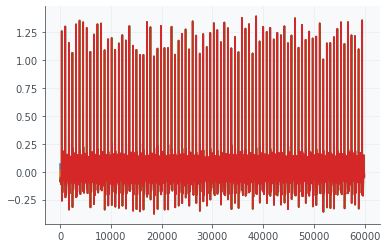

In [799]:
fig, axes = plt.subplots()

print(embedded_signals[3].shape)
axes.plot(embedded_signals[0])
plt.show()

In [800]:
# performing SVD

from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Standardize the embedded signal
scaler = StandardScaler()
embedded_signal_std = scaler.fit_transform(embedded_signals[0])

# Perform SVD
U, S, VT = svd(embedded_signal_std, full_matrices=False)

# Get the principal components
PCs = U @ np.diag(S)

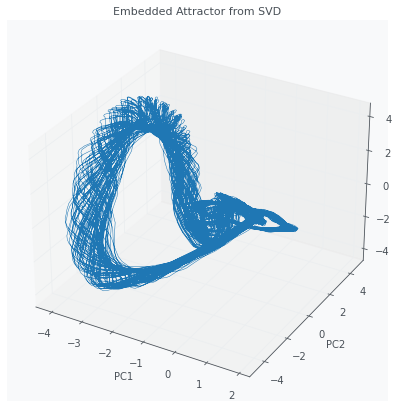

In [801]:
#visualising attractors in 3D
 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(PCs[:, 0], PCs[:, 1], PCs[:, 2], lw=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Embedded Attractor from SVD')

plt.show()

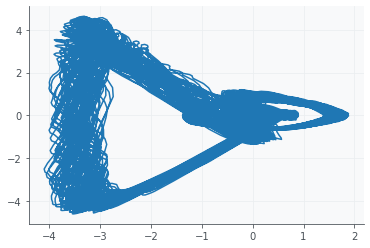

In [802]:
#in 2D

fig, axes = plt.subplots()

axes.plot(PCs[:, 0], PCs[:, 1])

In [803]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope

# Define box sizes
box_sizes = np.logspace(-1, 1, num=10)  # Adjust as needed

# Calculate the fractal dimension
fd = fractal_dimension(PCs[:, :3], box_sizes)  # Using the first three principal components

In [804]:
print(f"Fractal Dimension: {fd}")

Fractal Dimension: 1.6297867584344776


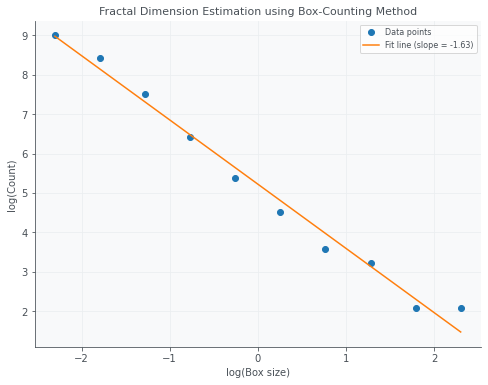

In [805]:
# plotting the log-log plot for the box-counting method
import matplotlib.pyplot as plt

log_box_sizes = np.log(box_sizes)
log_counts = np.log(box_counting(PCs[:, :3], box_sizes))

plt.figure(figsize=(8, 6))
plt.plot(log_box_sizes, log_counts, 'o', label='Data points')
plt.plot(log_box_sizes, np.polyval(np.polyfit(log_box_sizes, log_counts, 1), log_box_sizes),
         label=f'Fit line (slope = {-fd:.2f})')
plt.xlabel('log(Box size)')
plt.ylabel('log(Count)')
plt.legend()
plt.title('Fractal Dimension Estimation using Box-Counting Method')
plt.show()

Code to calculate fractal dimension only for each patient:

In [806]:
#research this properly before doing this final implementation but this allows calculation of just fractal dimension from all signals
def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :3], box_sizes)  # uses the first three principal components
    return fd

fd = np.zeros(shape = len(signal_health_state))

for i in tqdm(range(0, len(signal_health_state))):
    fd[i] = calc_fractal_dim(embedded_signals[i])
    


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:25<00:00,  2.06it/s]


In [807]:
fd_averages = print_averages(fd, 'fd', test_nan_indices)


Unhealthy fd: mean:1.5961366444367828, std: 0.08404061904279536
Healthy fd: mean:1.6340218832536888, std:0.06063684491490118
